## DataMUX (CNNs)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
# grayscale and inline plotting
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

### Visualization

In [3]:
def plot_image(image):
    nr, nc = image.shape
    extent = [-0.5, nc - 0.5, nr - 0.5, -0.5]
    plt.imshow(image, extent=extent, origin='upper', interpolation='nearest')

def visualize(t, loss, errcl, out, x0):

    loss_avg = np.divide(
        np.cumsum(loss[: t + 1]),
        range(1, t + 2)
    )

    errcl_avg = np.divide(
        np.cumsum(errcl[: t + 1]),
        range(1, t + 2)
    )

    n_last_batches = np.min([20, t])
    k = np.ones(n_last_batches * 2 + 1) / (n_last_batches + 1)
    k[:n_last_batches] = 0
    
    errcl_sm = np.convolve(np.pad(errcl, mode="edge", pad_width=n_last_batches), k, mode="valid")
    errcl_sm = errcl_sm[: len(errcl_avg)]

    loss_sm = np.convolve(np.pad(loss, mode="edge", pad_width=n_last_batches), k, mode="valid")
    loss_sm = loss_sm[: len(loss)]

    display.clear_output(wait=True)

    plt.subplot(1, 4, 1)
    plt.plot(loss, label="loss")
    plt.plot(loss_sm, label="smothed loss")
    plt.plot(loss_avg, label="avg loss")
    plt.legend()
    plt.ylim(0, np.max(loss)*1.05)
    plt.title("loss: avg - %.4f,\nsmoothed - %.4f,\ncurrent - %.4f"  % (loss_avg[t], loss_sm[t], loss[t]))

    plt.subplot(1, 4, 2)
    plt.plot(errcl, label="cl err")
    plt.plot(errcl_sm, label="smothed cl err")
    plt.plot(errcl_avg, label="avg cl err")
    plt.legend()
    plt.ylim(0, np.max(errcl)*1.05)
    plt.title("cl error: avg - %.4f,\nsmoothed - %.4f,\ncurrent - %.4f"  % (errcl_avg[t], errcl_sm[t], errcl[t]))

    plt.subplot(1, 4, 3)
    plot_image(x0)
    plt.title("input image")
    
    plt.subplot(1, 4, 4)
    plt.bar(range(len(out)), out)
    plt.title("class confidences")

    plt.subplots_adjust(wspace=1.5)
    plt.subplots_adjust(hspace=1.5)
    plt.gcf().set_size_inches(24.5, 5.5)
    display.display(plt.gcf())

### Data Preparation

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
mnist = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.data
trainlabels = mnist.targets

mnist = torchvision.datasets.MNIST(root='data', train=False, download=True) # test data only
testimages = mnist.data
testlabels = mnist.targets

# check training data shape
print("Training Data shape is: ", list(trainimages.size()))
print("Training Target shape is: ", list(trainlabels.size()))
print("Training Data shape is: ", list(testimages.size()))
print("Training Target shape is: ", list(testlabels.size()))

100%|██████████| 9912422/9912422 [00:00<00:00, 266818837.40it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 64986960.21it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 129705390.03it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8075679.85it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training Data shape is:  [60000, 28, 28]
Training Target shape is:  [60000]
Training Data shape is:  [10000, 28, 28]
Training Target shape is:  [10000]


In [6]:
tempimg = np.zeros((20,20))

In [7]:
# crop images into 20 x 20
trainimages = trainimages[:, 4:-4, 4:-4]
testimages = testimages[:, 4:-4, 4:-4]

In [8]:
tempimg[5:10,0:5] = trainimages[0][0::4,0::4]

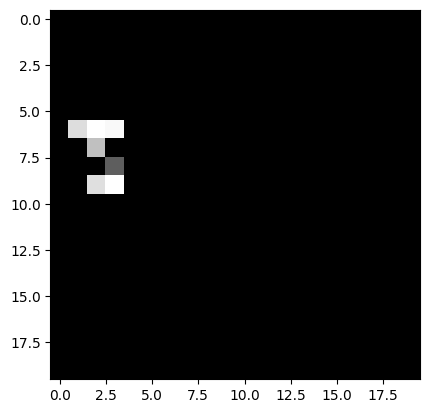

In [9]:
plt.imshow(tempimg)

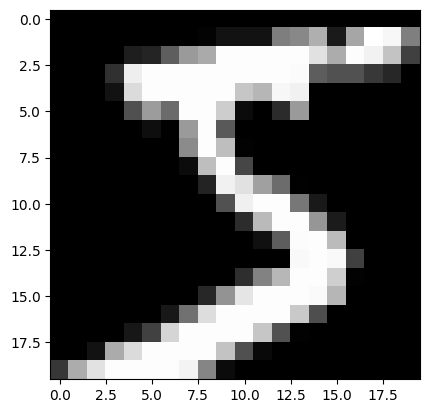

In [10]:
plt.imshow(trainimages[0])

In [11]:

%%time
def auto_cov(X):
    X = X / 255.0
    X = (X.T - X.mean(1)).T
    return X.T.dot(X)/X.shape[0]

Cov = auto_cov(trainimages.contiguous().view(trainimages.size(0), -1).numpy())

CPU times: user 676 ms, sys: 206 ms, total: 882 ms
Wall time: 545 ms


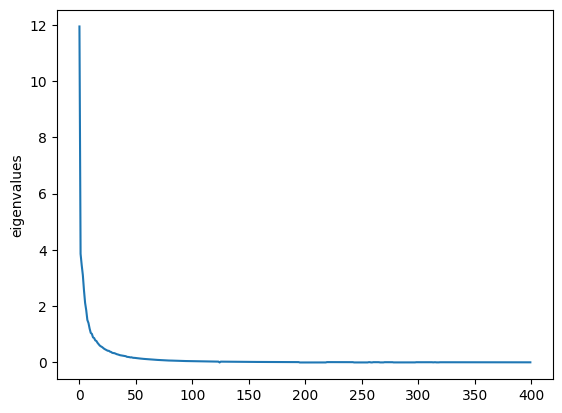

In [12]:
eigvals, eigvecs = np.linalg.eig(Cov)
plt.plot(np.arange(len(eigvals)), eigvals)
plt.ylabel("eigenvalues")
plt.show()

In [13]:
print("{:.2f}% variance explained by top 50 PCs".format(100*eigvals[:50].sum()/eigvals.sum()))
print("{:.2f}% variance explained by top 80 PCs".format(100*eigvals[:80].sum()/eigvals.sum()))

86.54% variance explained by top 50 PCs
92.08% variance explained by top 80 PCs


### Single Instance Architecture

In [14]:
class LeNet(nn.Module):

    # definition of each neural network layer
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.C1 = nn.Conv2d(1, 6, kernel_size=(3, 3))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(6, 16, kernel_size=(4, 4))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C5 = nn.Conv2d(16, 120, kernel_size=(3, 3))
        self.F6 = nn.Linear(120, 84)
        self.OL = nn.Linear(84, 10)

    # definition of the forward pass
    def forward(self, x):
        
        x = torch.tanh(self.C1(x))
        x = self.S2(x)
        x = torch.tanh(self.C3(x))
        x = self.S4(x)
        x = torch.tanh(self.C5(x))
        x = x.view(x.size(0), -1) 
        x = torch.tanh(self.F6(x))
        x = torch.tanh(self.OL(x))
        
        return x

### Training

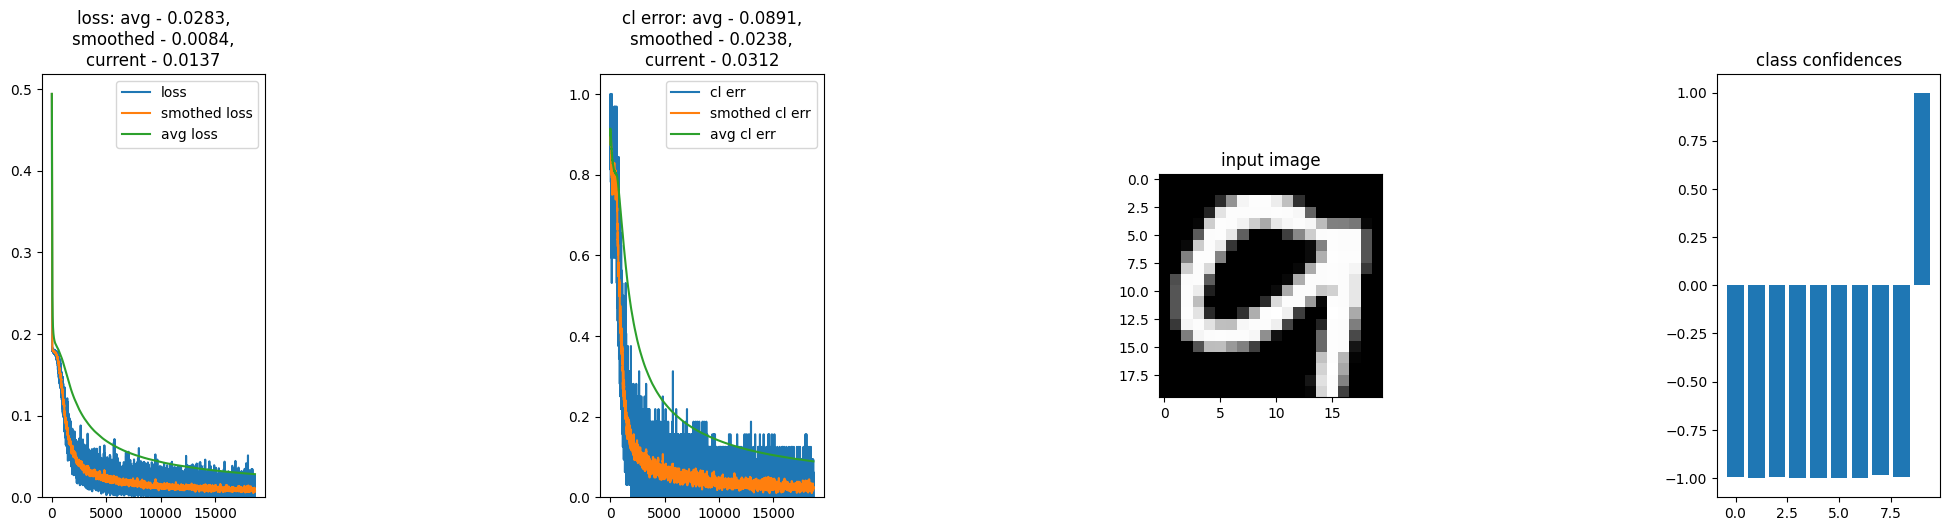

2.158781051635742 seconds per 200 iterations


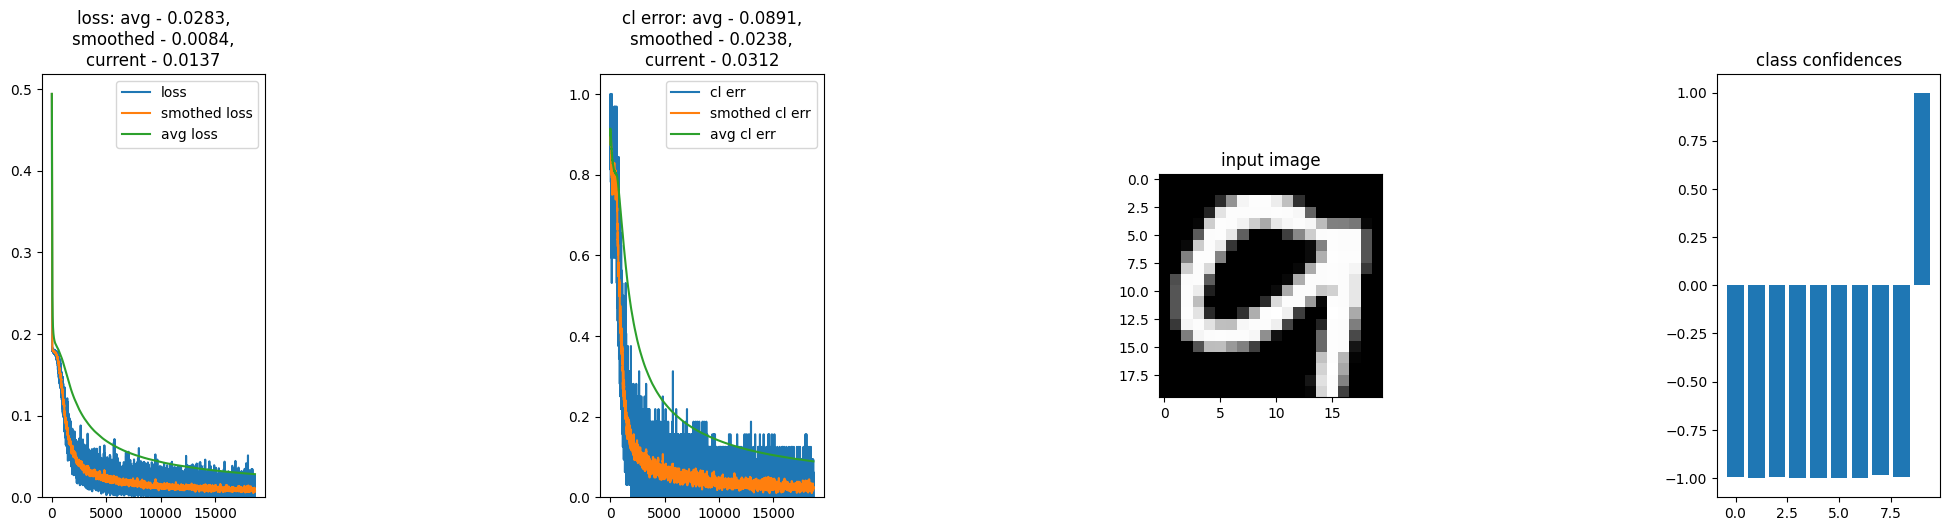

In [31]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10;                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size

errs = []
losses = []

cnn = LeNet().to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(cnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        
        # label 1 for the correct digit and -1 for the incorrect digits
        y = torch.ones(10, batchsize) * (-1)
        y[trainlabels_iter, torch.arange(batchsize, dtype=torch.int64)] = 1

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.

        optimizer.zero_grad()
        out = cnn(imgs.view(len(batchindices), 1, 20, 20).to(device))
        loss = torch.mean(0.5*(y.to(device) - out.t())**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != trainlabels_iter.to(device)).float())
        errs.append(err.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

        
        # plots
        if (t + 1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(len(errs) - 1, losses, errs, out[0,:].detach().cpu(), imgs[0].detach().cpu())
            print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
            t_start = time.time()
            time.sleep(0.01)

In [32]:
%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
out = cnn(imgs.view(ntest, 1, 20, 20).to(device))
pred = torch.argmax(out, dim=1)
err = torch.mean((pred != testlabels.to(device)).float())

print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 97.59%
CPU times: user 23.6 ms, sys: 12.1 ms, total: 35.7 ms
Wall time: 40.6 ms


### Multiple Instance Architecture

In [15]:
from scipy.stats import ortho_group, special_ortho_group
from scipy import ndimage

class MuxLeNet(nn.Module):

    # definition of each neural network layer
    def __init__(self, K, mod='Gaussian'):
        super(MuxLeNet, self).__init__()
        
        self.K = K
        
        self.C1 = nn.Conv2d(1, 10, kernel_size=(3, 3))
        self.S2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C3 = nn.Conv2d(10, 16, kernel_size=(4, 4))
        self.S4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.C5 = nn.Conv2d(16, 120, kernel_size=(3, 3))
        self.F6 = nn.Linear(120, 84)
        
        self.DCs = nn.ModuleList([nn.Linear(84, 84) for _ in range(self.K)])
        
        self.OL = nn.Linear(84, 10)
        
        self.mod = mod
        if mod == 'Gaussian':
            self.rop = [torch.randn([1,1,3,3], requires_grad=False).to(device) for _ in range(K)]
        elif mod == 'graded':
            # identity projections, fixed
            self.rop = [(g+1) * torch.ones([1,1,3,3], requires_grad=False).to(device) for g in range(K)]
        elif mod == 'identity':
            # identity projections, fixed
            self.rop = [torch.ones([1,1,3,3], requires_grad=False).to(device) for _ in range(K)]
        elif mod == 'learnable':
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,1,1,3,3])))
        elif mod == 'SO(N)':
            self.rop = [torch.Tensor(special_ortho_group.rvs(dim=400)).to(device) for _ in range(self.K)]
        elif mod == 'learnable-W':
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,400,400])))
        elif mod == 'nonlinear':
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,16,1,3,3])))
            self.register_parameter(name='rop2', param=torch.nn.Parameter(torch.randn([K,1,16,3,3])))
        elif mod == 'nonlinear-expand':
#             self.expand_factor = 4
            self.expand_factor = 8
            self.register_parameter(name='rop', param=torch.nn.Parameter(torch.randn([K,16,1,3,3])))
            self.register_parameter(name='rop2', param=torch.nn.Parameter(
                                                  torch.randn([K,self.expand_factor,16,3,3])))
            self.C1 = nn.Conv2d(self.expand_factor, 10, kernel_size=(3, 3))
        elif mod == 'rotation':
            self.rop = [360 / K * i for i in range(K)]
        elif mod == 'remap':
            self.rop = [i for i in range(K)]
        
    def proj(self, imgs):
        comp_imgs = torch.zeros(imgs.shape[1], imgs.shape[2], 
                                imgs.shape[3], imgs.shape[4]).to(device)
        if self.mod == 'rotation':
            for i, r in enumerate(self.rop):
                comp_imgs += torch.from_numpy((1-2*i) * ndimage.rotate(imgs[i].cpu().numpy(), angle=r, 
                                                                       axes=(2,3), reshape=False)).to(device)
        elif self.mod == 'remap':
            for i, r in enumerate(self.rop):
                row = r % 4
                col = r // 4
                comp_imgs[:, 5*row:5*(row+1), 5*col:5*(col+1)] += imgs[i][:,::4,::4]
        elif self.mod in ['SO(N)', 'learnable-W']:
            for i, r in enumerate(self.rop):
                comp_imgs += imgs[i].view(-1, 400).mm(r).view(imgs.shape[1], -1, 20, 20)
        elif self.mod == 'nonlinear':
            for i, r in enumerate(self.rop):
                tmp_imgs = nn.functional.conv2d(imgs[i], weight=r, padding=1)
                tmp_imgs = torch.tanh(tmp_imgs)
                tmp_imgs = nn.functional.conv2d(tmp_imgs, weight=self.rop2[i], padding=1)
                comp_imgs += torch.tanh(tmp_imgs)
        elif self.mod == 'nonlinear-expand':
            comp_imgs = torch.zeros(imgs.shape[1], self.expand_factor * imgs.shape[2], 
                                imgs.shape[3], imgs.shape[4]).to(device)
            for i, r in enumerate(self.rop):
                tmp_imgs = nn.functional.conv2d(imgs[i], weight=r, padding=1)
                tmp_imgs = torch.tanh(tmp_imgs)
                tmp_imgs = nn.functional.conv2d(tmp_imgs, weight=self.rop2[i], padding=1)
                comp_imgs += torch.tanh(tmp_imgs)
        else:
            for i, r in enumerate(self.rop):
                comp_imgs += nn.functional.conv2d(imgs[i], weight=r, padding=1)
        return comp_imgs   
        
    # definition of the forward pass
    def forward(self, x):
        
        x = torch.tanh(self.C1(x))
        x = self.S2(x)
        x = torch.tanh(self.C3(x))
        x = self.S4(x)
        x = torch.tanh(self.C5(x))
        x = x.view(x.size(0), -1) 
        x = torch.tanh(self.F6(x))
        out = [torch.tanh(self.OL(torch.tanh(dc(x)))) for dc in self.DCs]
            
        return out

### Sanity Check, K = 1

#### mod = rotation

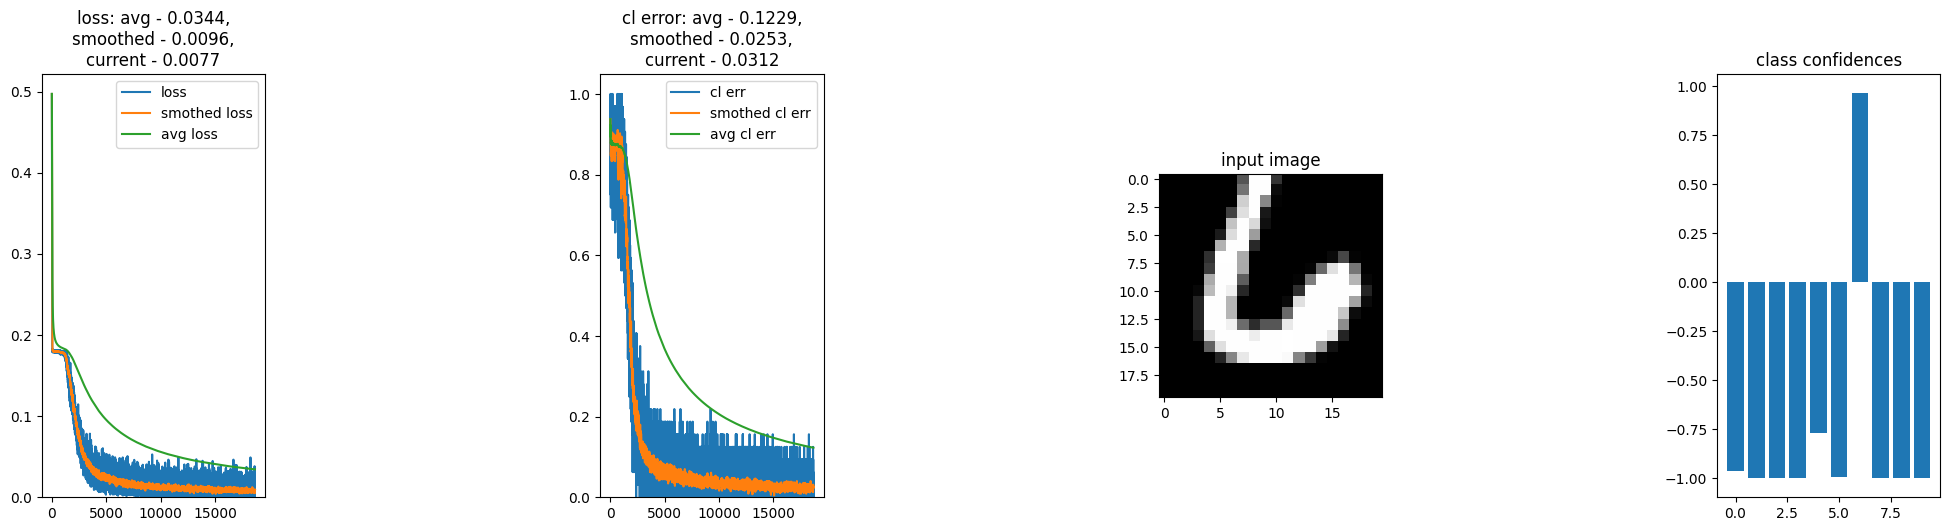

2.3331217765808105 seconds per 200 iterations


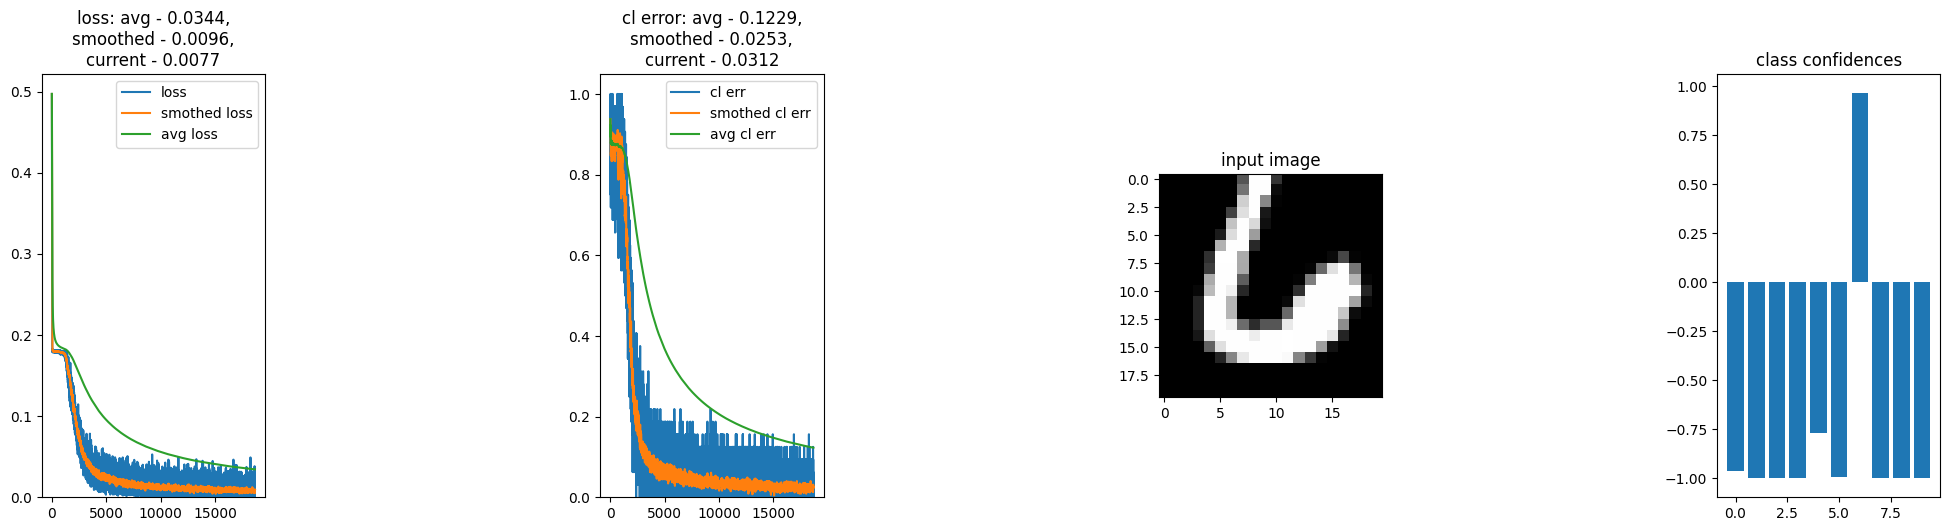

In [34]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 1                          # multiplex

errs = []
losses = []

muxcnn = MuxLeNet(K, 'rotation').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].to(device) - out.t())**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs.append(err.detach().cpu().numpy())
            losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs) - 1, losses, errs, out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [35]:
%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 97.78%
CPU times: user 831 ms, sys: 10.9 ms, total: 842 ms
Wall time: 848 ms


#### mod = Gaussian

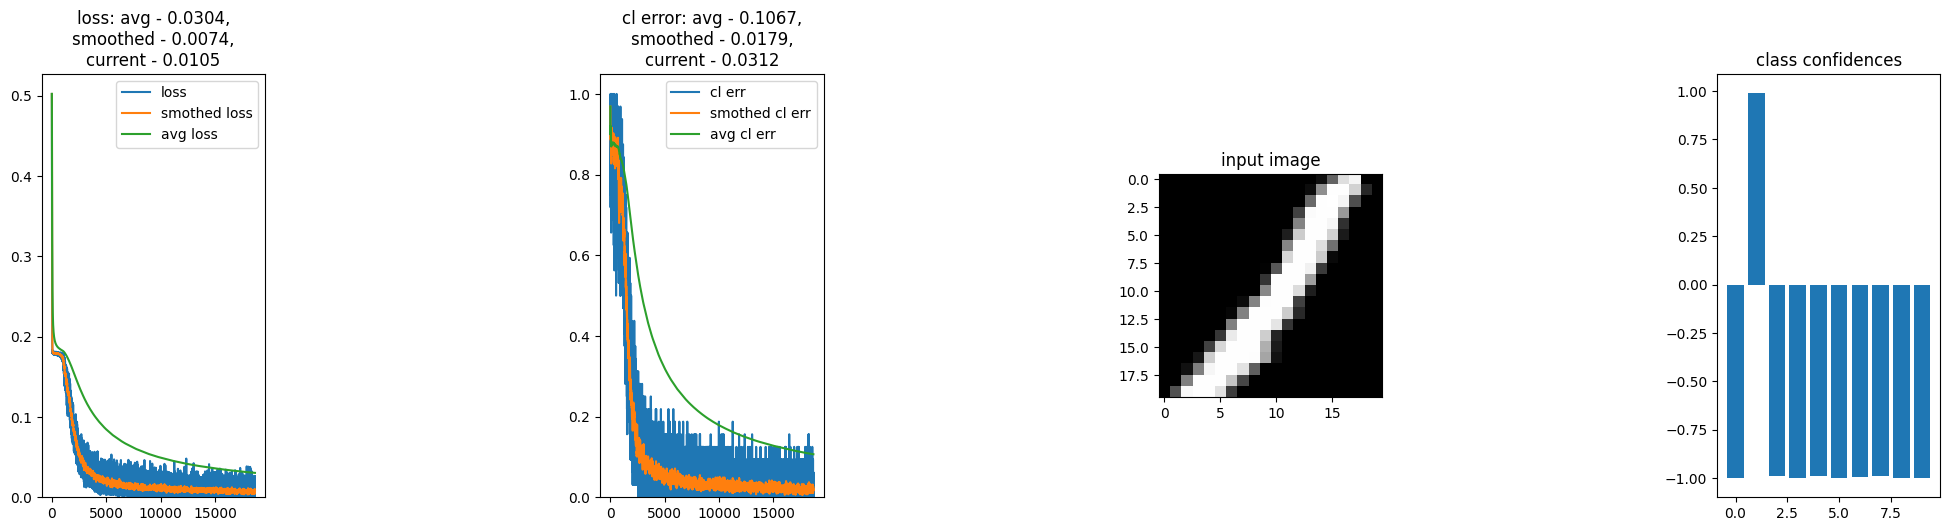

1.99367094039917 seconds per 200 iterations


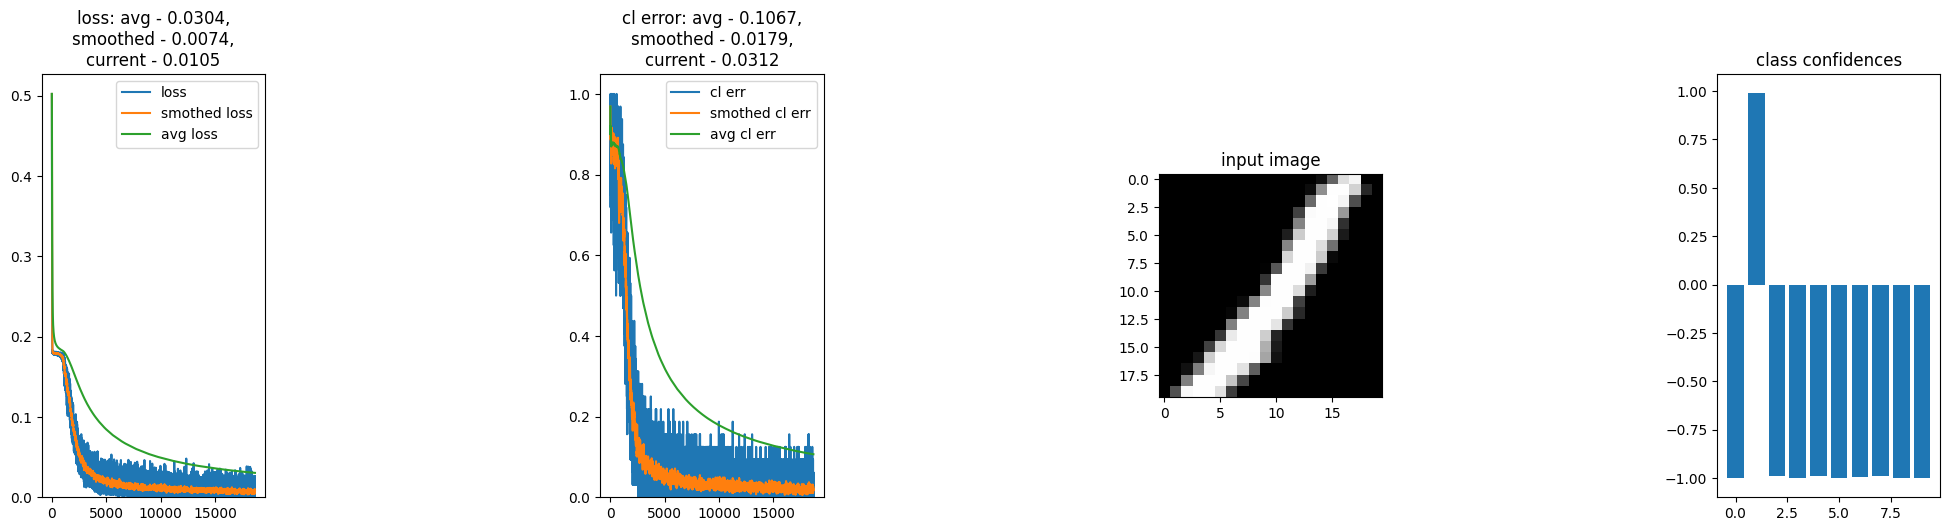

In [36]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 1                          # multiplex

errs = []
losses = []

muxcnn = MuxLeNet(K, 'Gaussian').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].to(device) - out.t())**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs.append(err.detach().cpu().numpy())
            losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs) - 1, losses, errs, out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [37]:
%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 98.09%
CPU times: user 56.6 ms, sys: 0 ns, total: 56.6 ms
Wall time: 56.6 ms


#### mod = non-linear

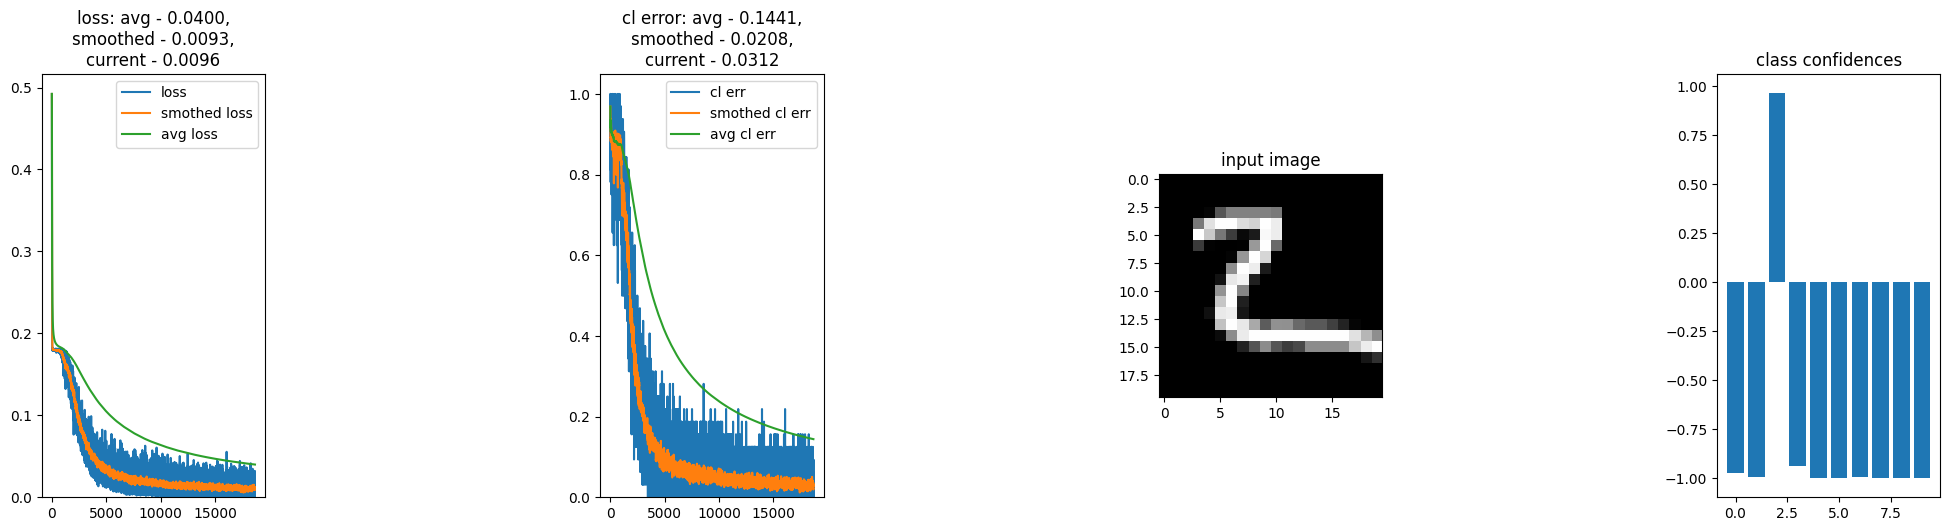

1.8380439281463623 seconds per 200 iterations


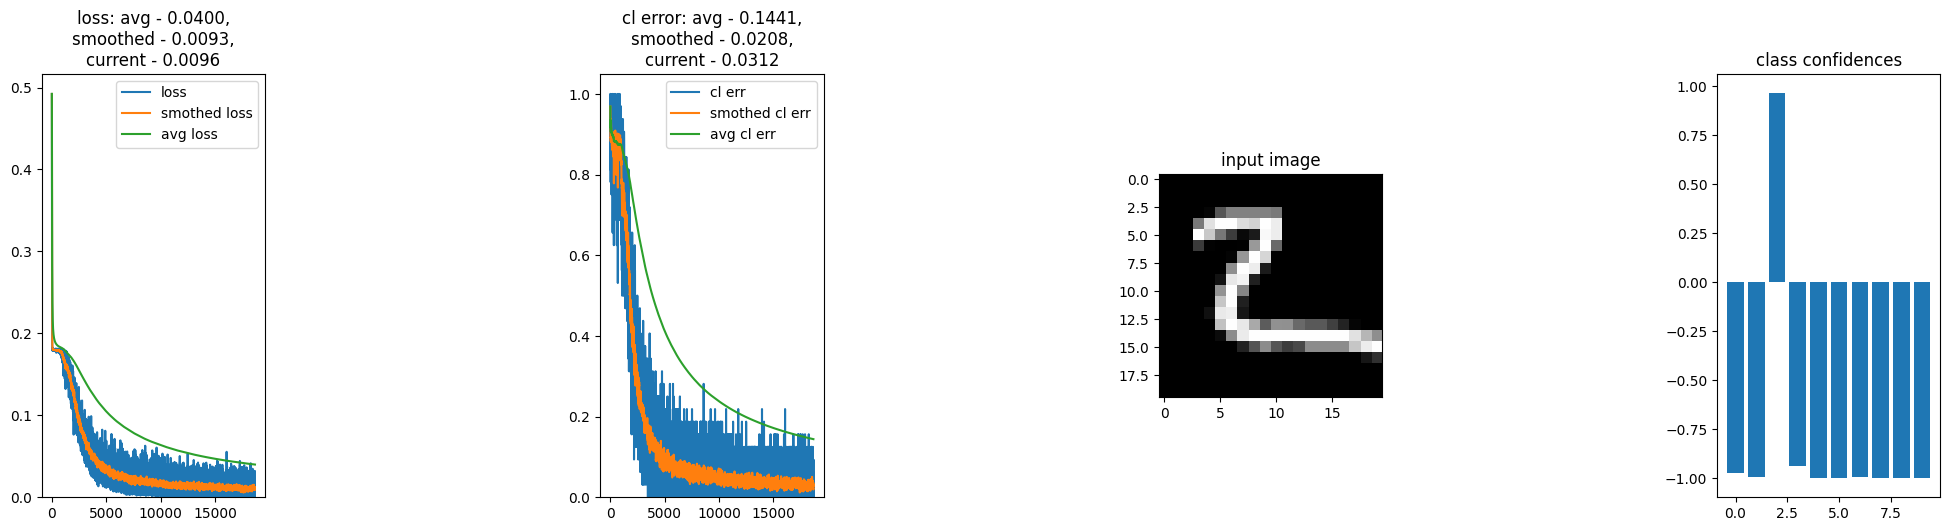

In [38]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 1                          # multiplex

errs = []
losses = []

muxcnn = MuxLeNet(K, 'nonlinear').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].to(device) - out.t())**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs.append(err.detach().cpu().numpy())
            losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs) - 1, losses, errs, out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [39]:
%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 97.08%
CPU times: user 66.8 ms, sys: 980 µs, total: 67.7 ms
Wall time: 70 ms


### Sanity Check, K=2

#### mod = rotation

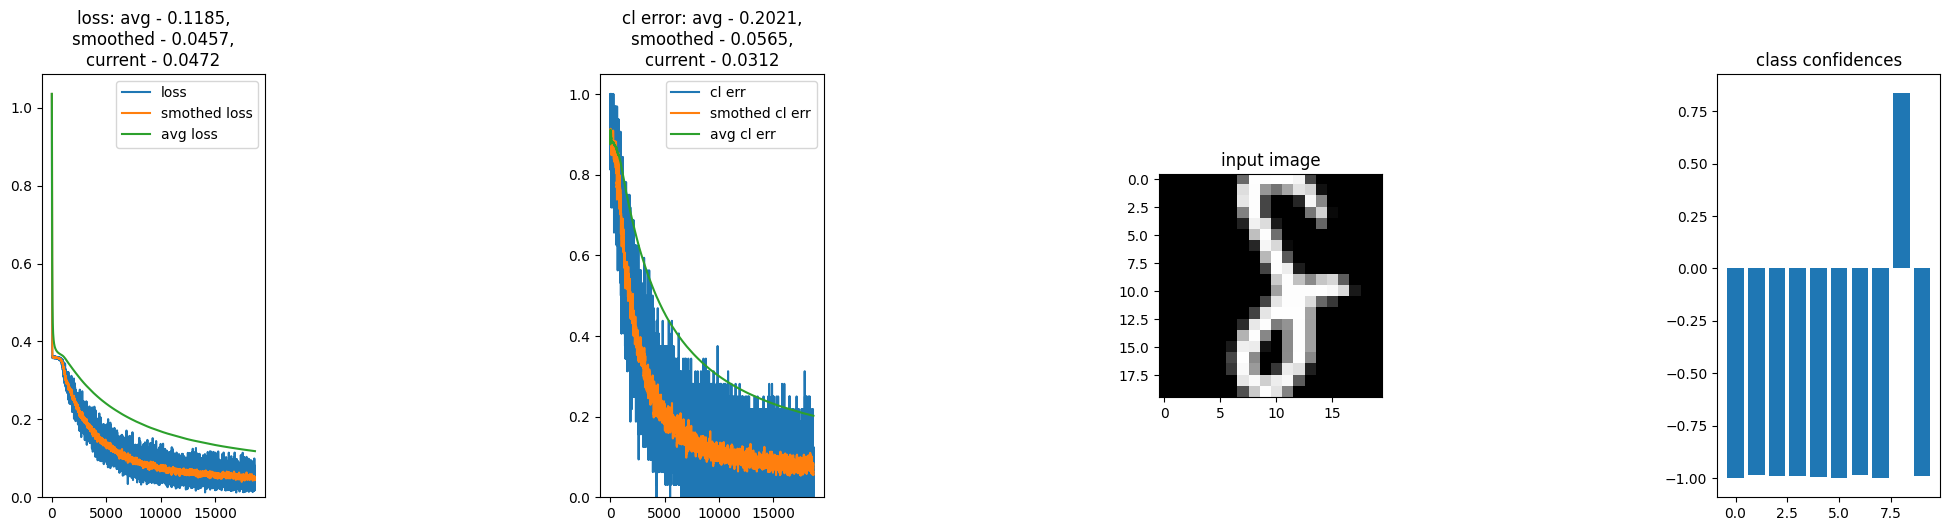

tensor(8, device='cuda:0')
0.863039493560791 seconds per 200 iterations


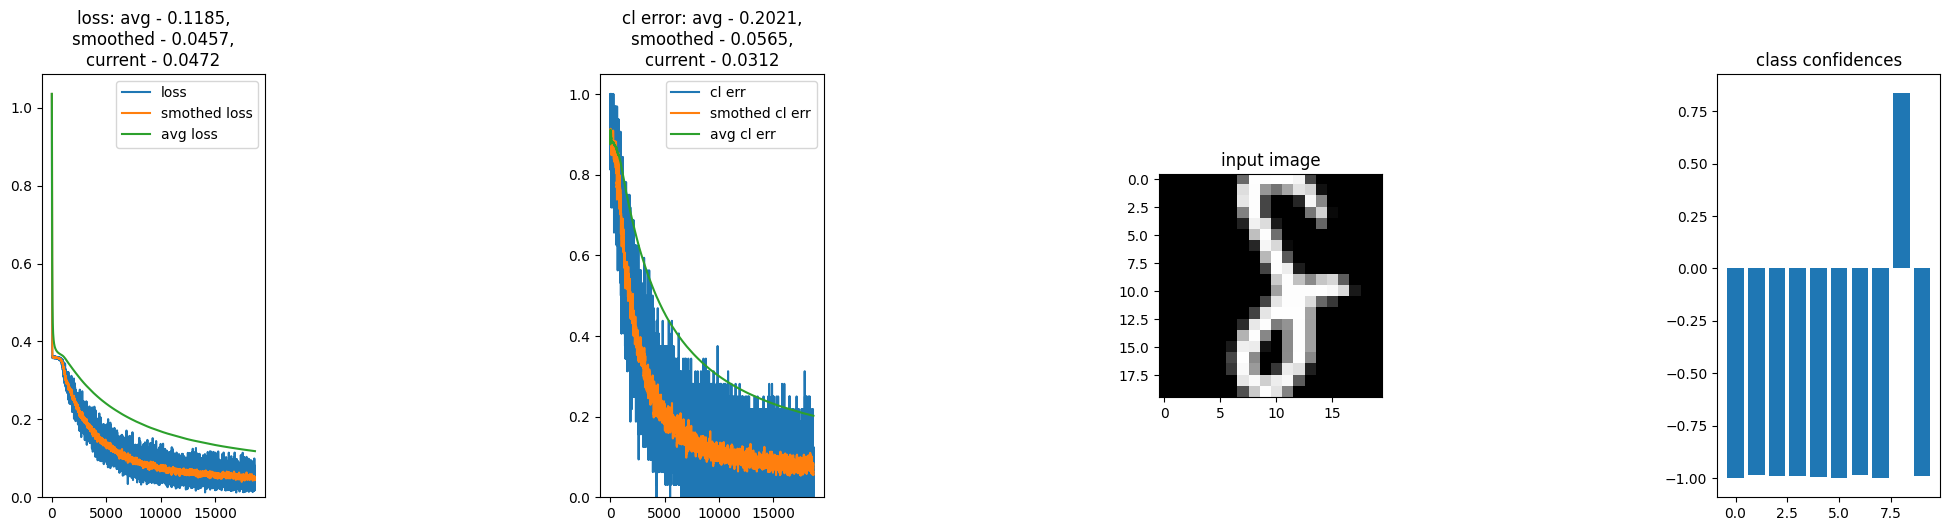

In [40]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 2                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'rotation').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [41]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 90.18%
Test Acc 95.44%
CPU times: user 1.37 s, sys: 15.6 ms, total: 1.38 s
Wall time: 1.47 s


#### mod = gaussian

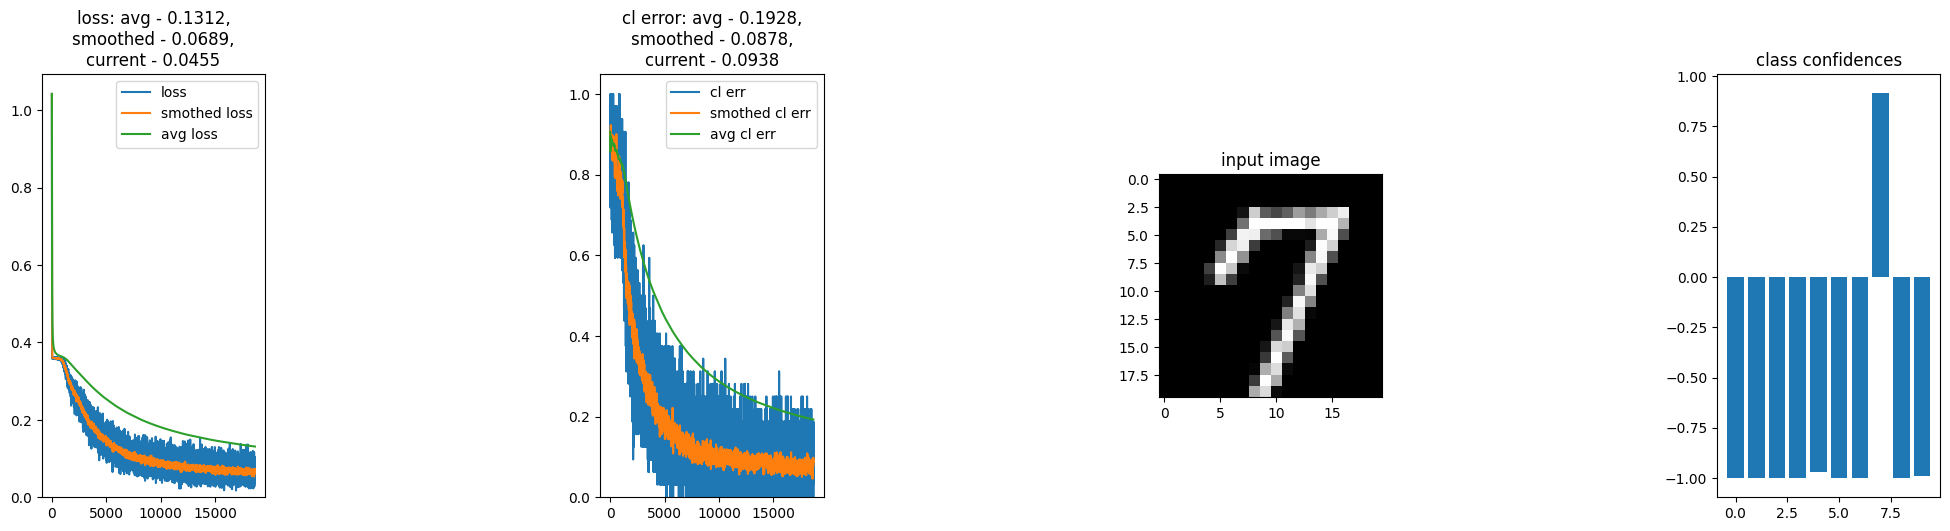

tensor(7, device='cuda:0')
0.9008629322052002 seconds per 200 iterations


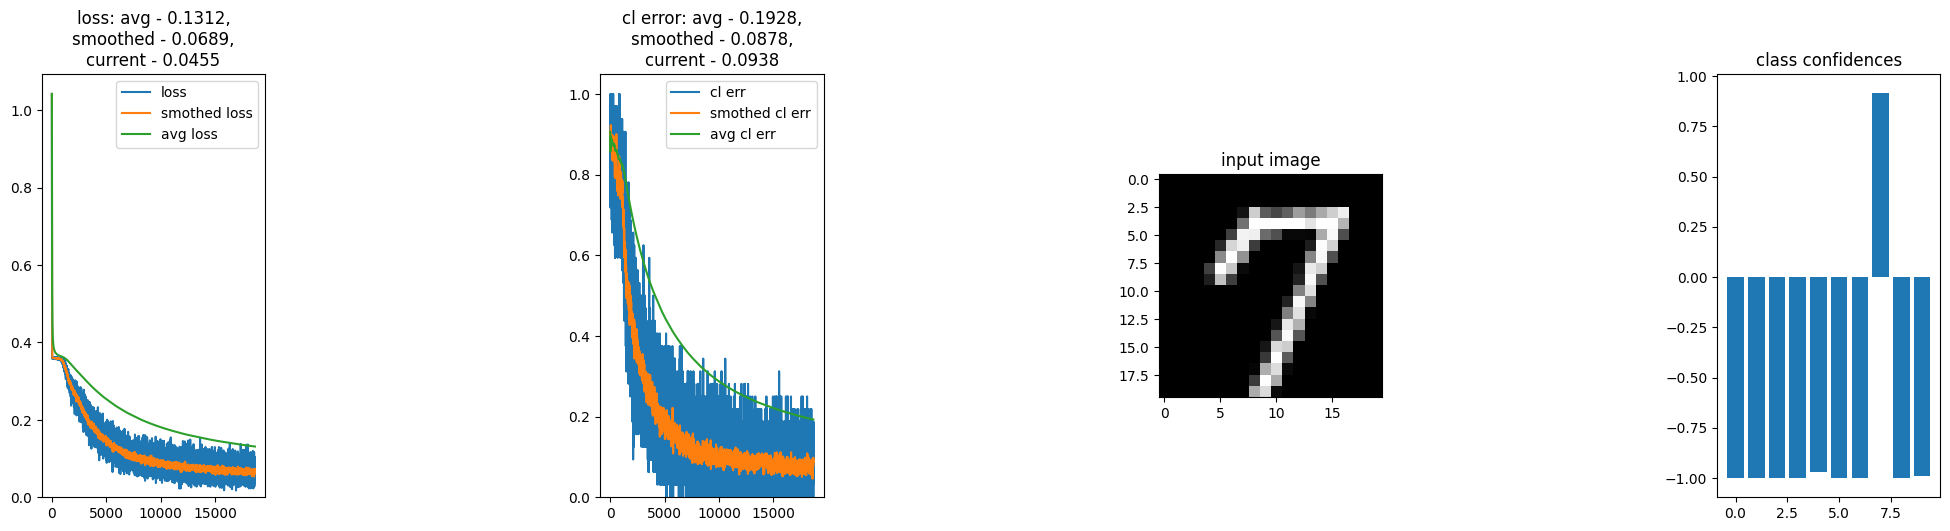

In [42]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                   # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 2                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'Gaussian').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [43]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 85.52%
Test Acc 95.50%
CPU times: user 39.8 ms, sys: 8 µs, total: 39.8 ms
Wall time: 42.4 ms


#### mod = nonlinear

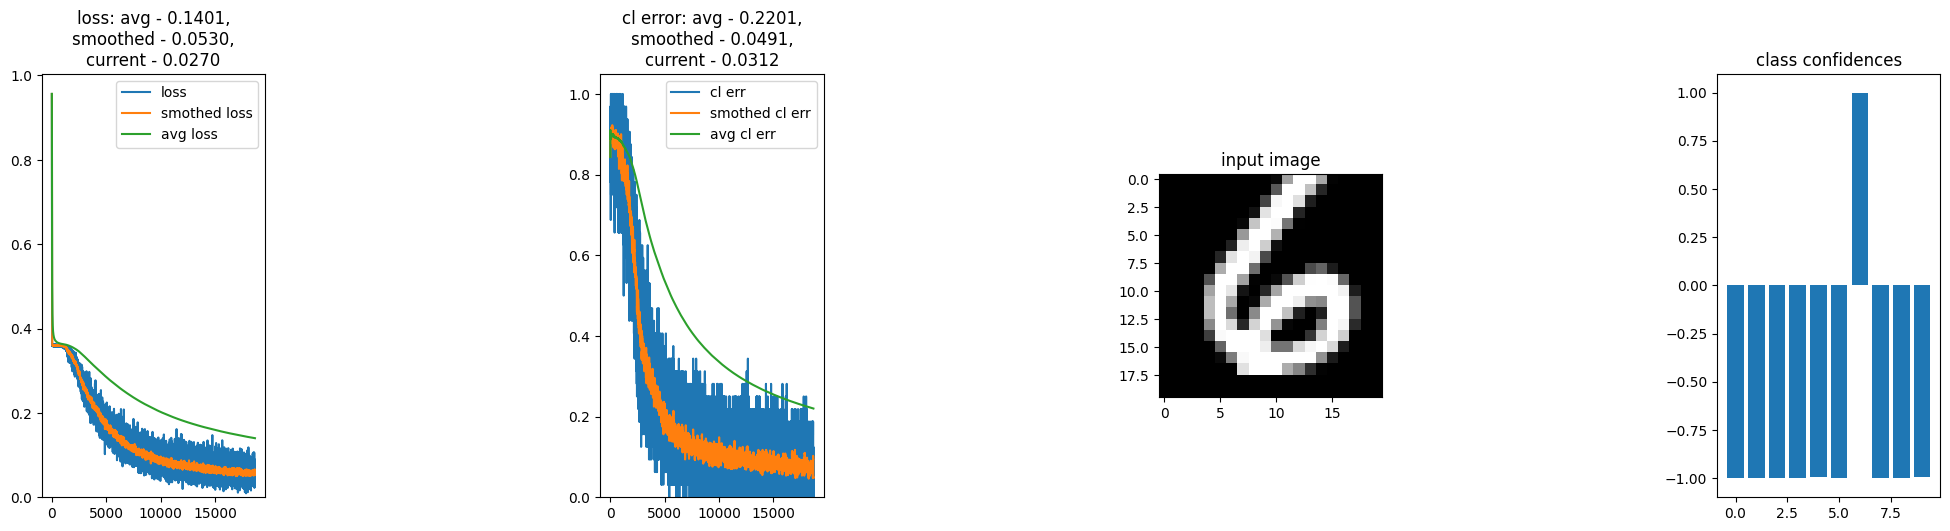

tensor(6, device='cuda:0')
0.8688681125640869 seconds per 200 iterations


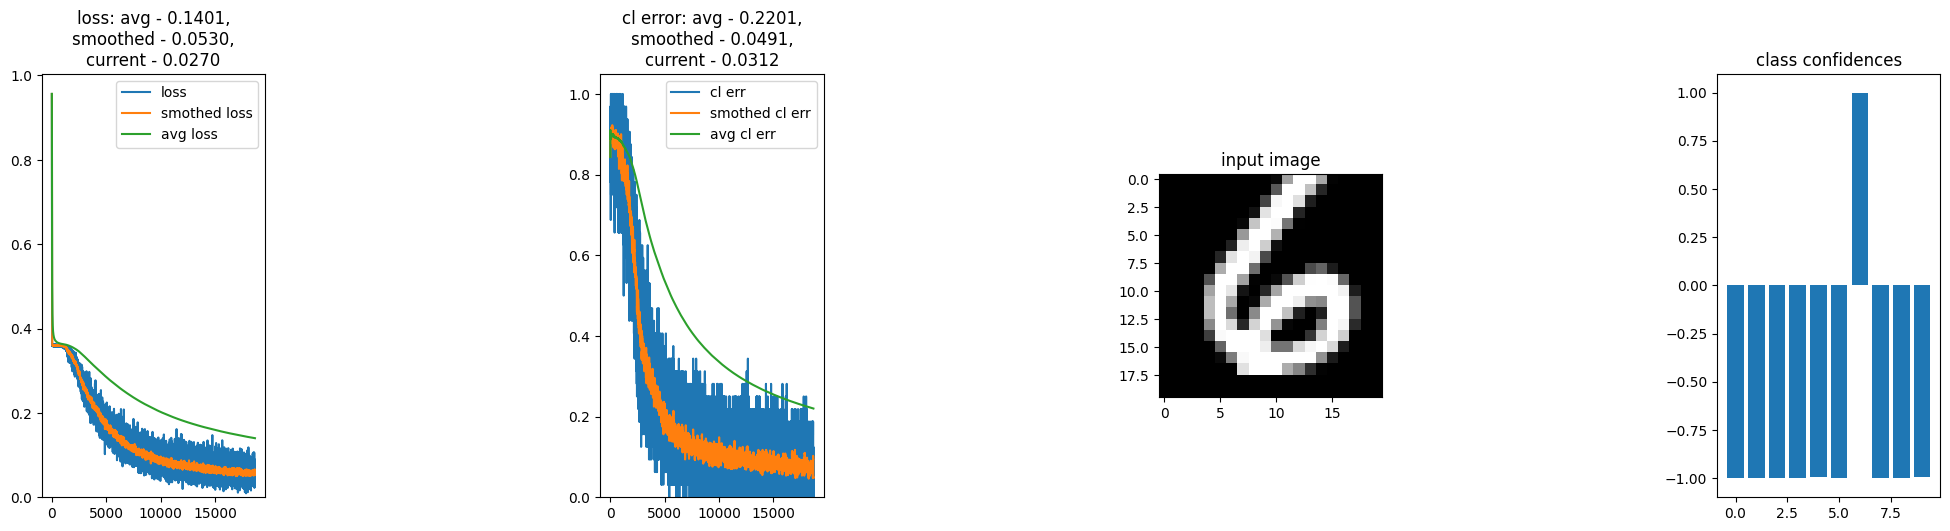

In [44]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 2                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'nonlinear').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [45]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 88.06%
Test Acc 95.36%
CPU times: user 53.6 ms, sys: 1.01 ms, total: 54.6 ms
Wall time: 54.2 ms


### Sanity check K = 4

#### mod = rotation

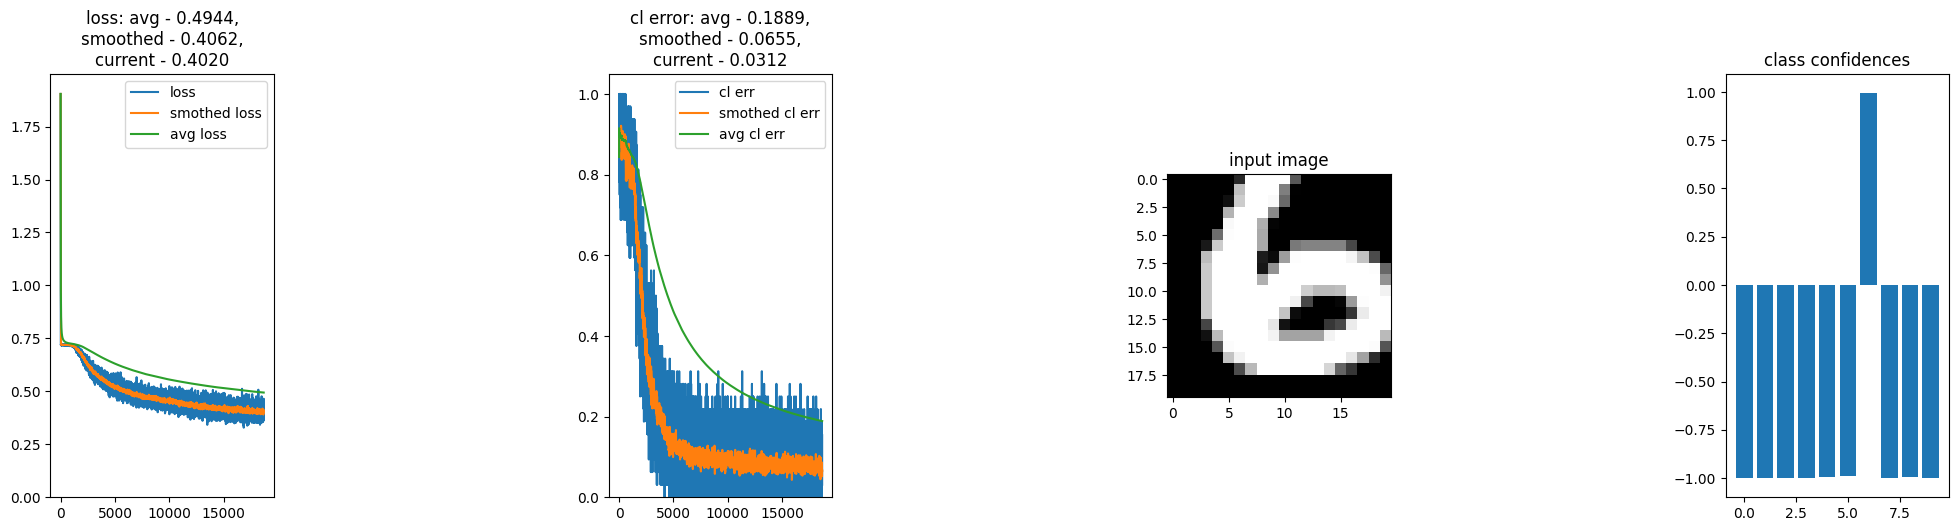

tensor(6, device='cuda:0')
0.901665449142456 seconds per 200 iterations


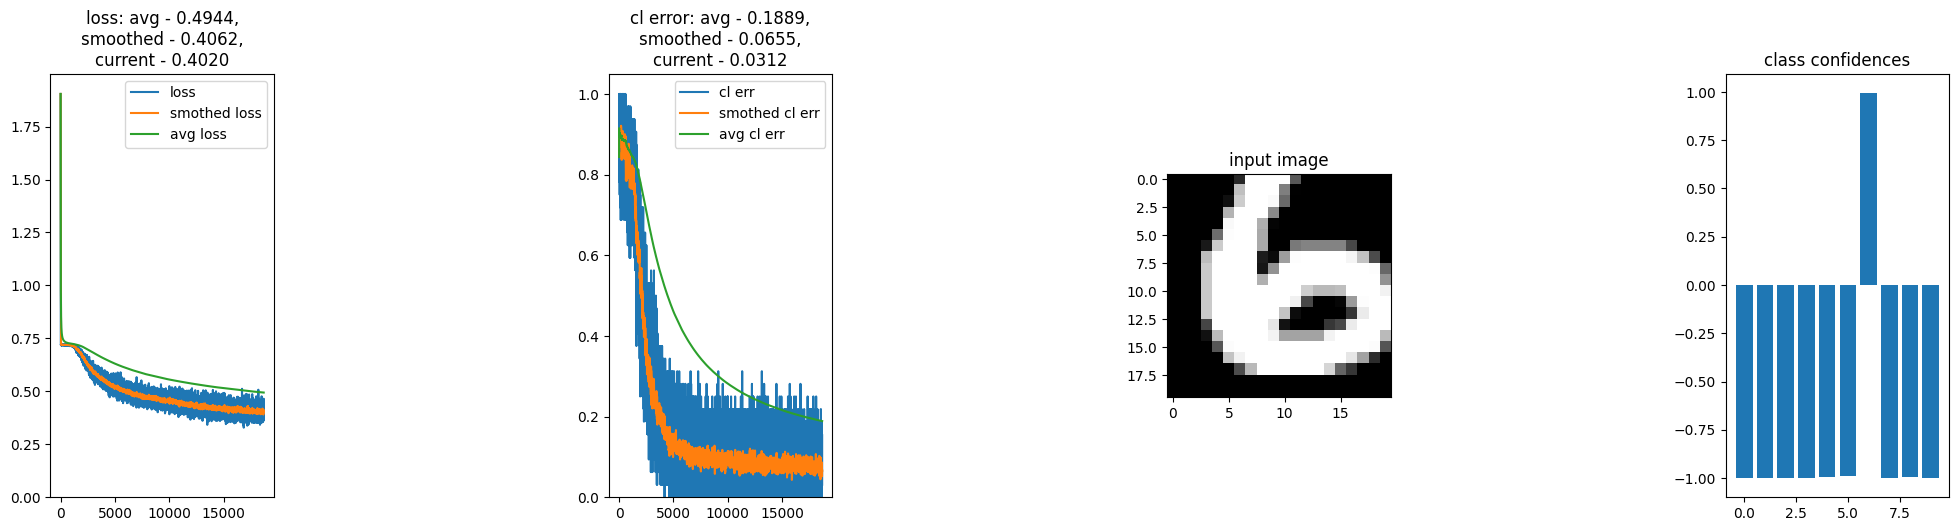

In [46]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 4                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'rotation').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [47]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 43.96%
Test Acc 21.24%
Test Acc 83.52%
Test Acc 95.20%
CPU times: user 814 ms, sys: 10 ms, total: 824 ms
Wall time: 830 ms


#### mod = gaussian

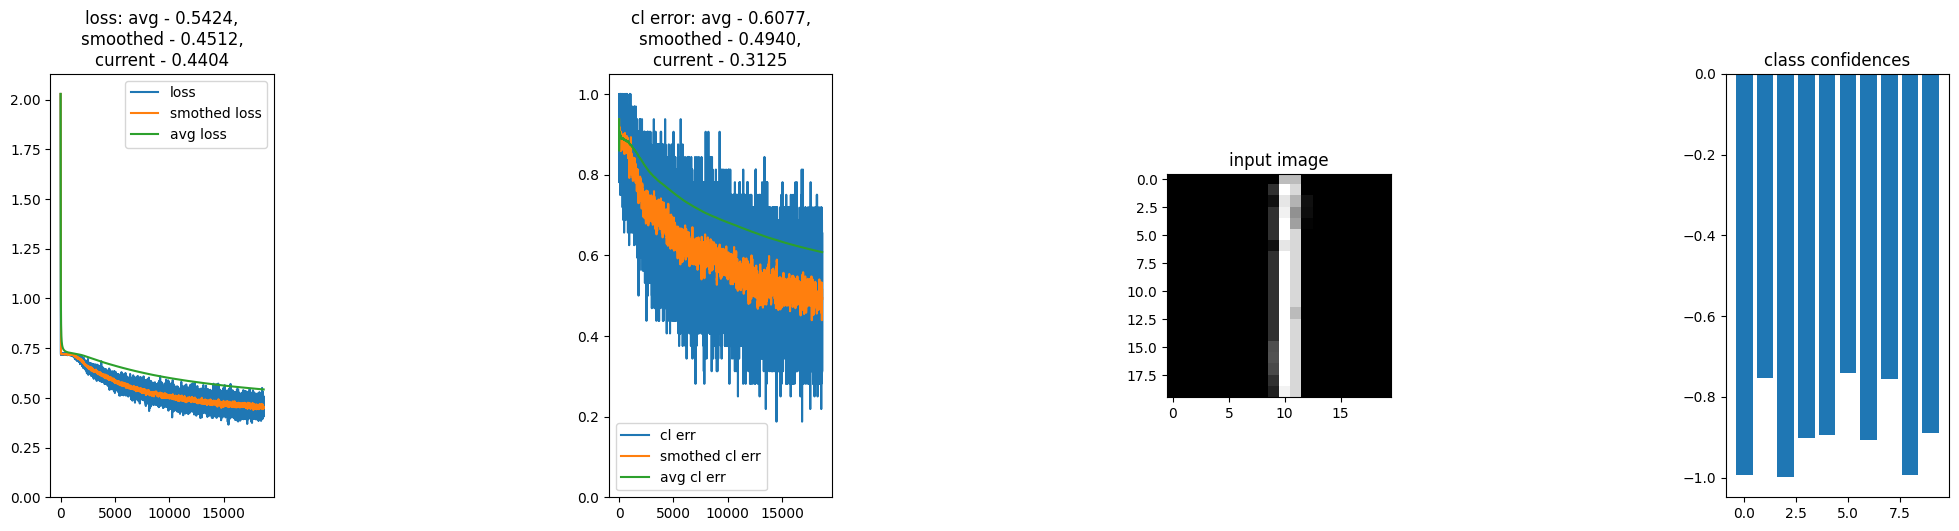

tensor(1, device='cuda:0')
1.3661763668060303 seconds per 200 iterations


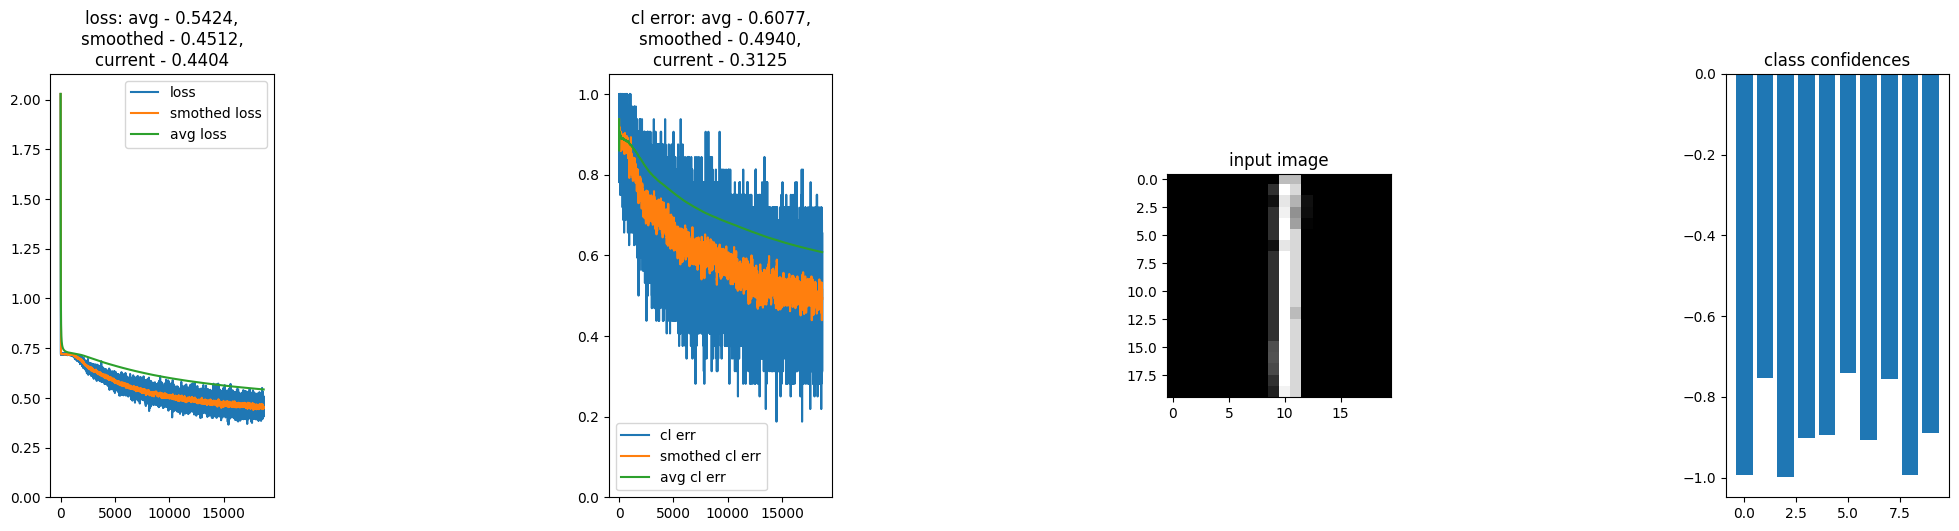

In [48]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                   # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 4                        # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'Gaussian').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [49]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 35.04%
Test Acc 53.60%
Test Acc 78.48%
Test Acc 55.08%
CPU times: user 29 ms, sys: 12.1 ms, total: 41.1 ms
Wall time: 48.8 ms


#### mod = nonlinear

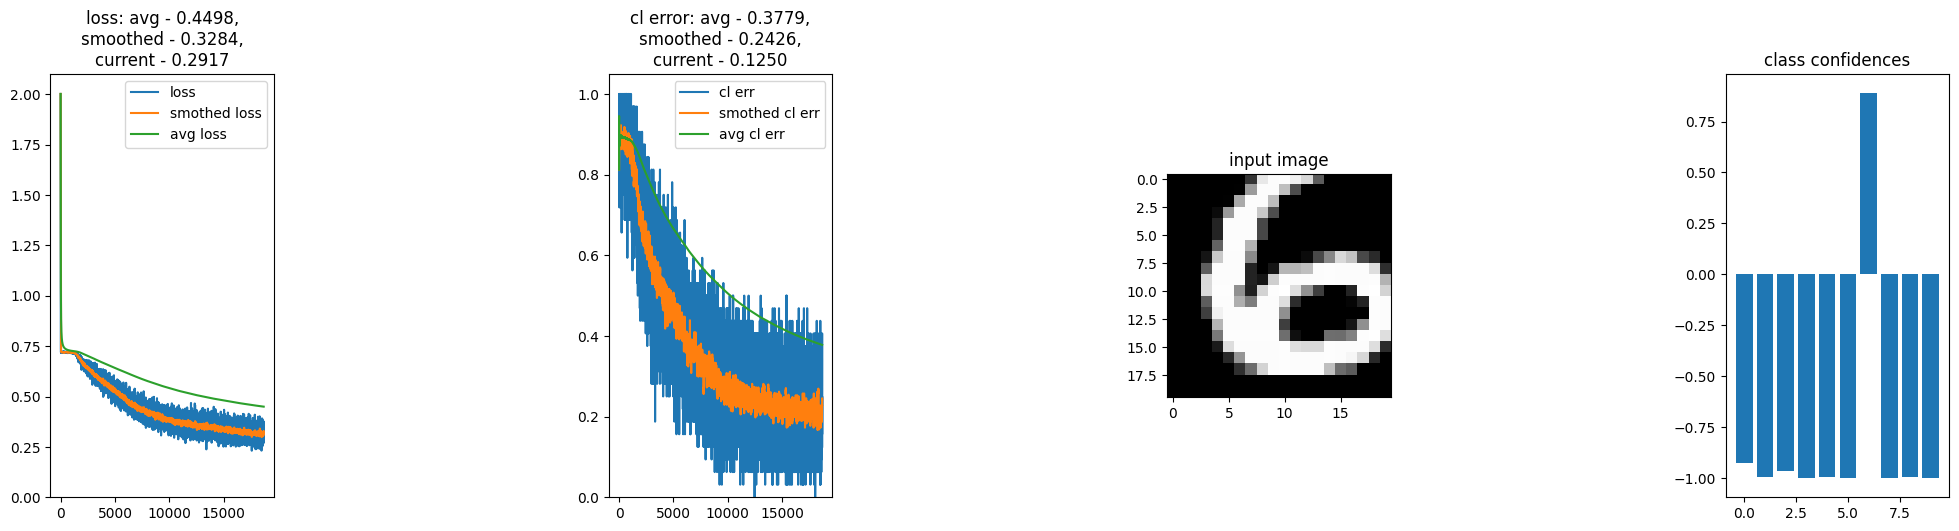

tensor(6, device='cuda:0')
0.9023792743682861 seconds per 200 iterations


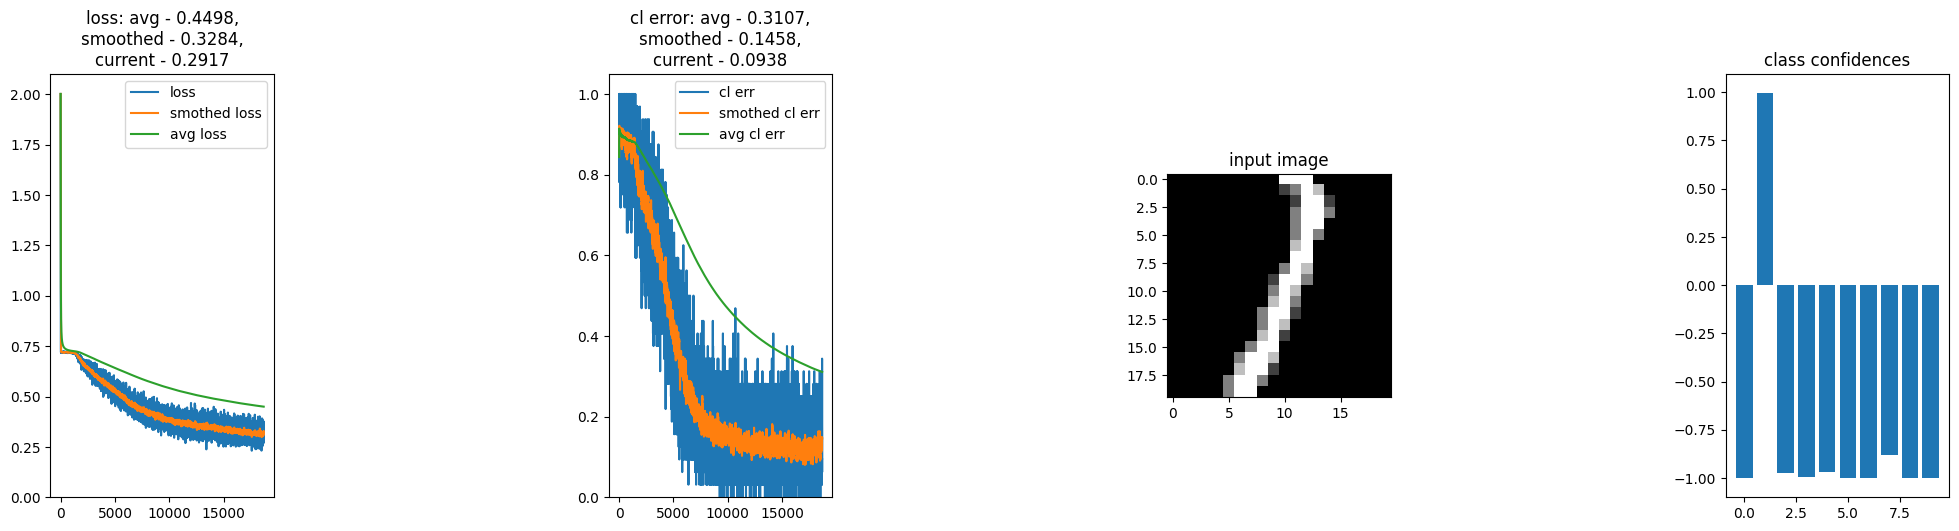

tensor(1, device='cuda:0')
0.91347336769104 seconds per 200 iterations


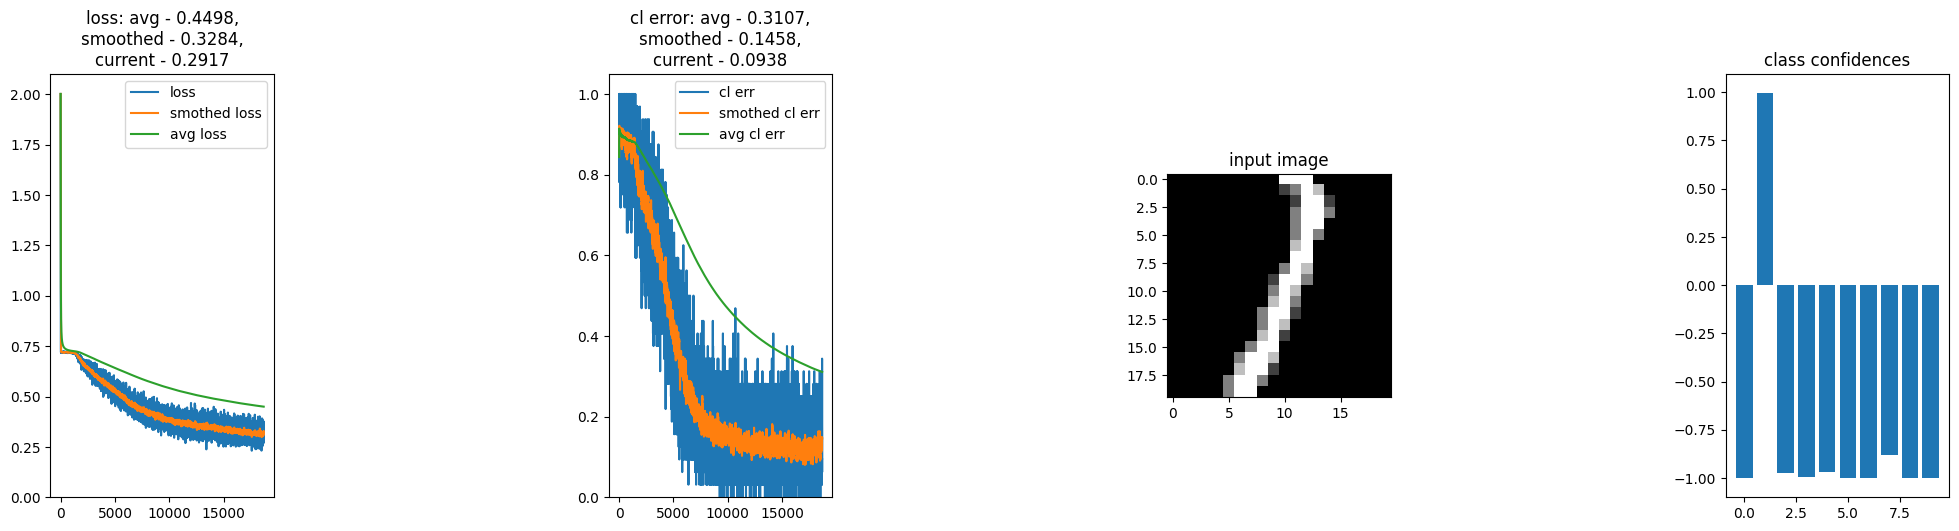

In [16]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                   # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 4                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'nonlinear').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [17]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 73.80%
Test Acc 45.20%
Test Acc 81.88%
Test Acc 91.04%
CPU times: user 44.7 ms, sys: 8.02 ms, total: 52.8 ms
Wall time: 52.6 ms


### Sanity check K = 8

#### mod = rotation

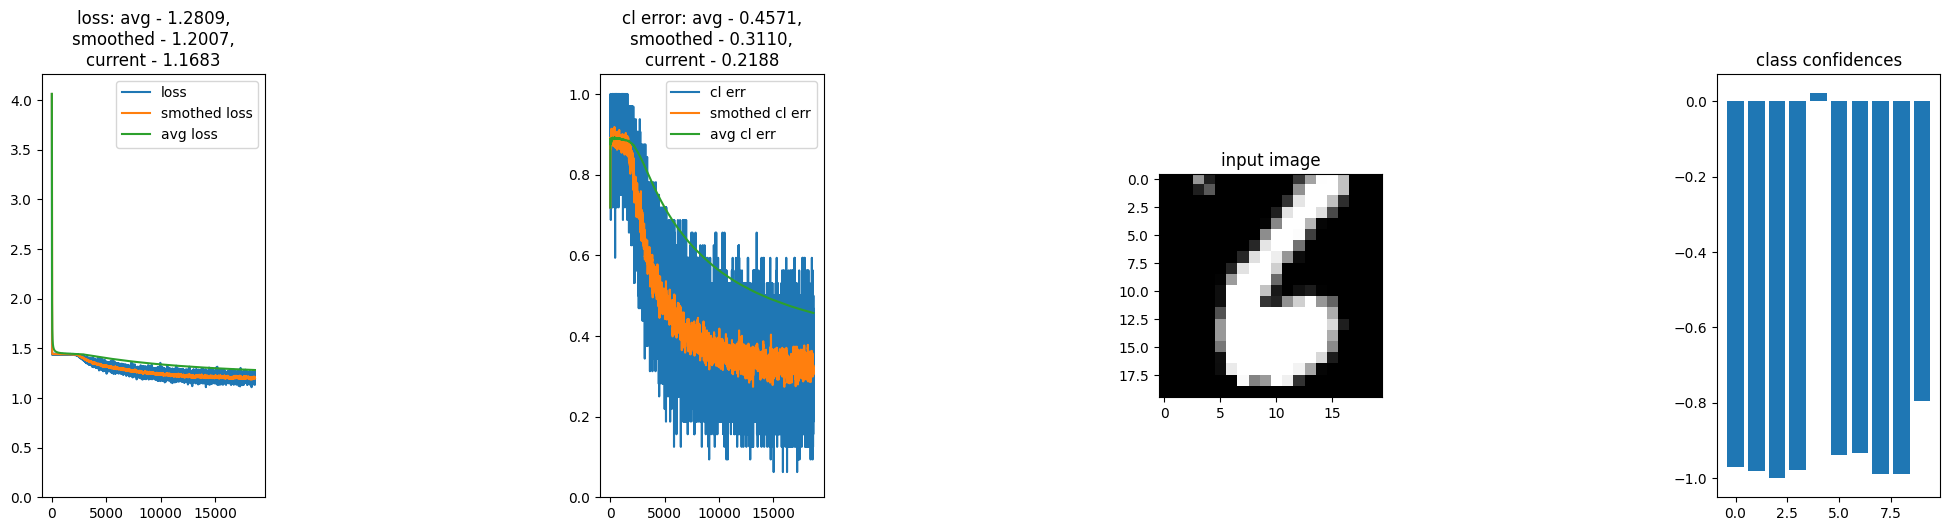

tensor(6, device='cuda:0')
1.4055171012878418 seconds per 200 iterations


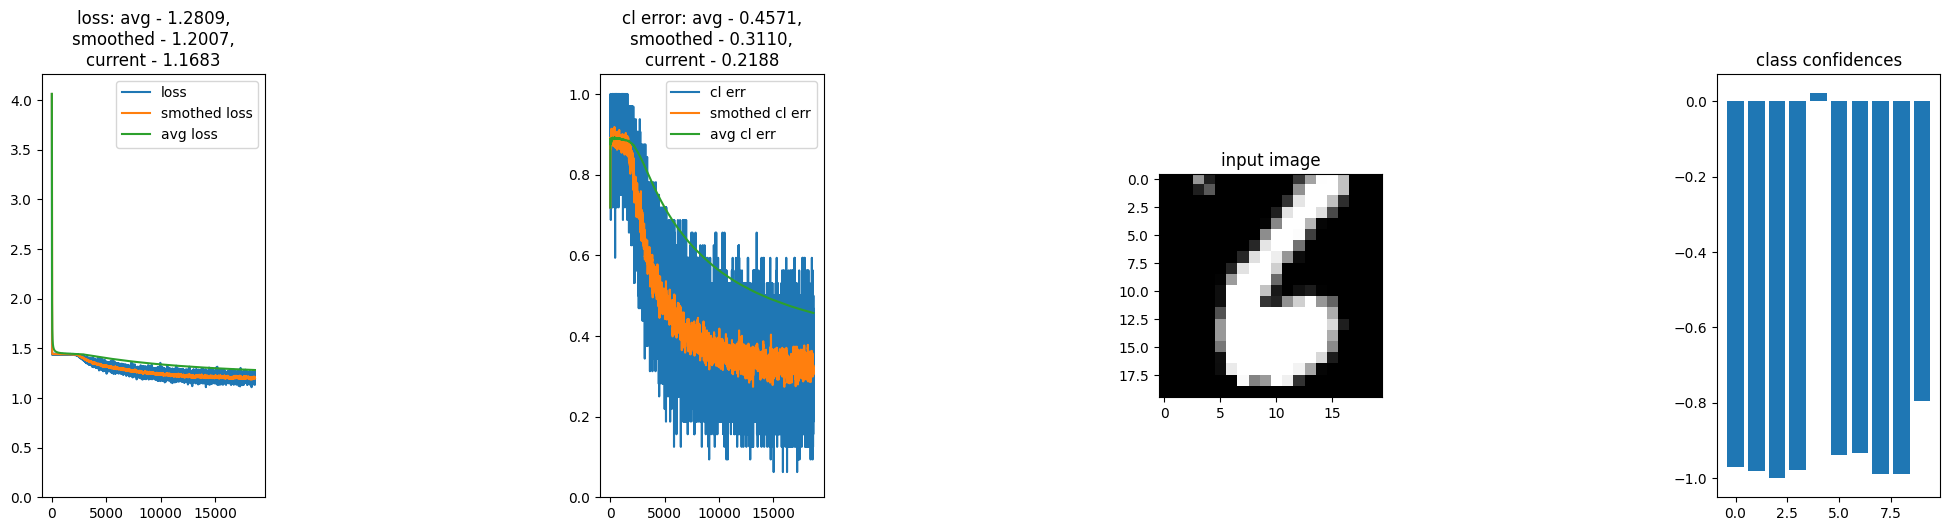

In [16]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 8                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'rotation').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [17]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 12.48%
Test Acc 11.12%
Test Acc 16.56%
Test Acc 20.48%
Test Acc 41.44%
Test Acc 52.64%
Test Acc 69.52%
Test Acc 71.92%
CPU times: user 820 ms, sys: 12 ms, total: 832 ms
Wall time: 849 ms


#### mod = gaussian

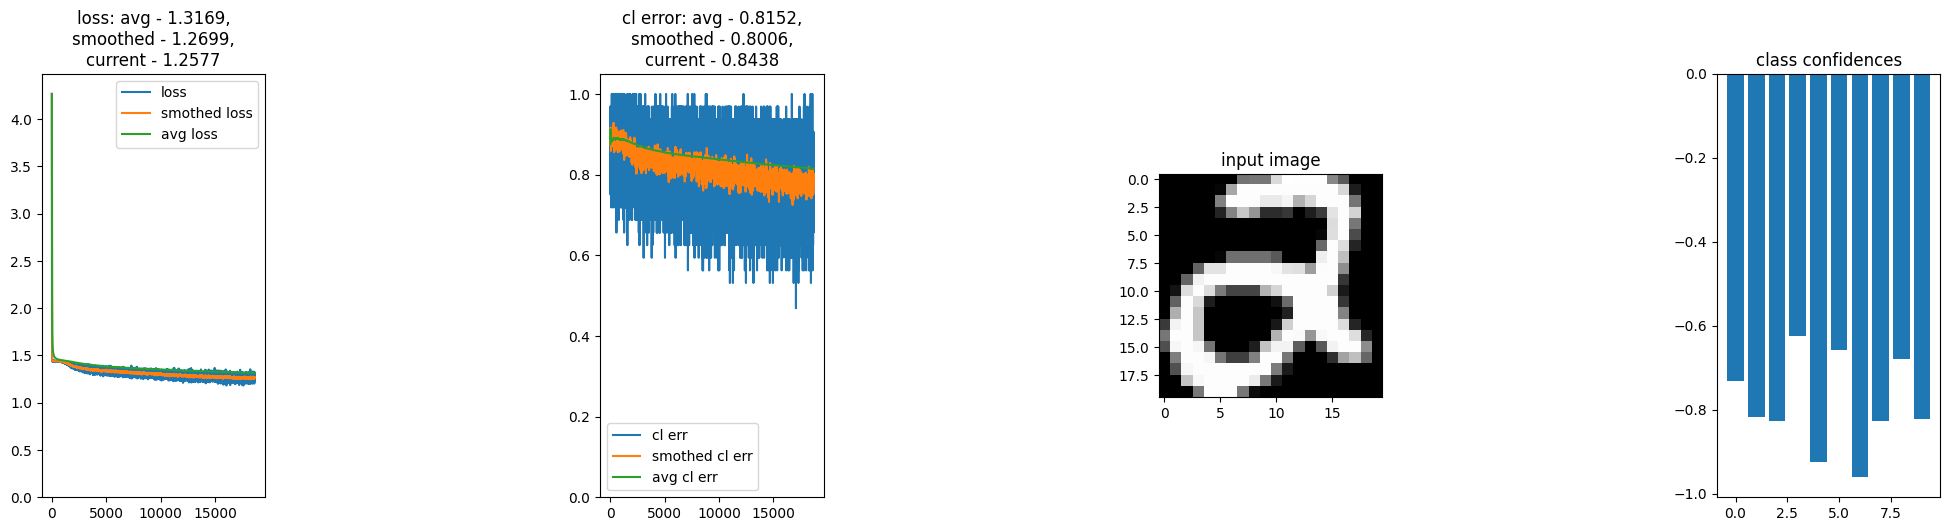

tensor(2, device='cuda:0')
1.3357739448547363 seconds per 200 iterations


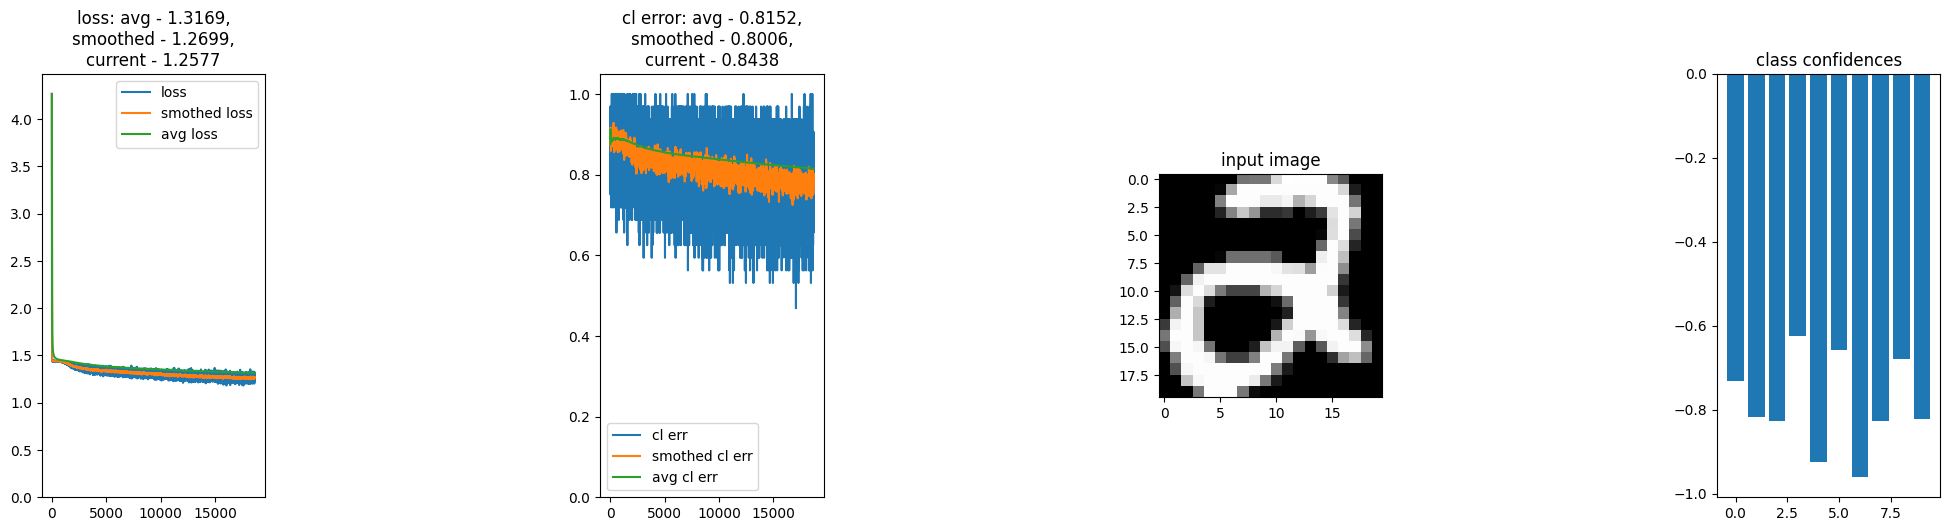

In [18]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                   # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 8                        # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'Gaussian').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [19]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 46.32%
Test Acc 30.72%
Test Acc 32.64%
Test Acc 31.76%
Test Acc 43.84%
Test Acc 28.56%
Test Acc 39.76%
Test Acc 21.92%
CPU times: user 33.5 ms, sys: 0 ns, total: 33.5 ms
Wall time: 39.3 ms


#### mod = nonlinear

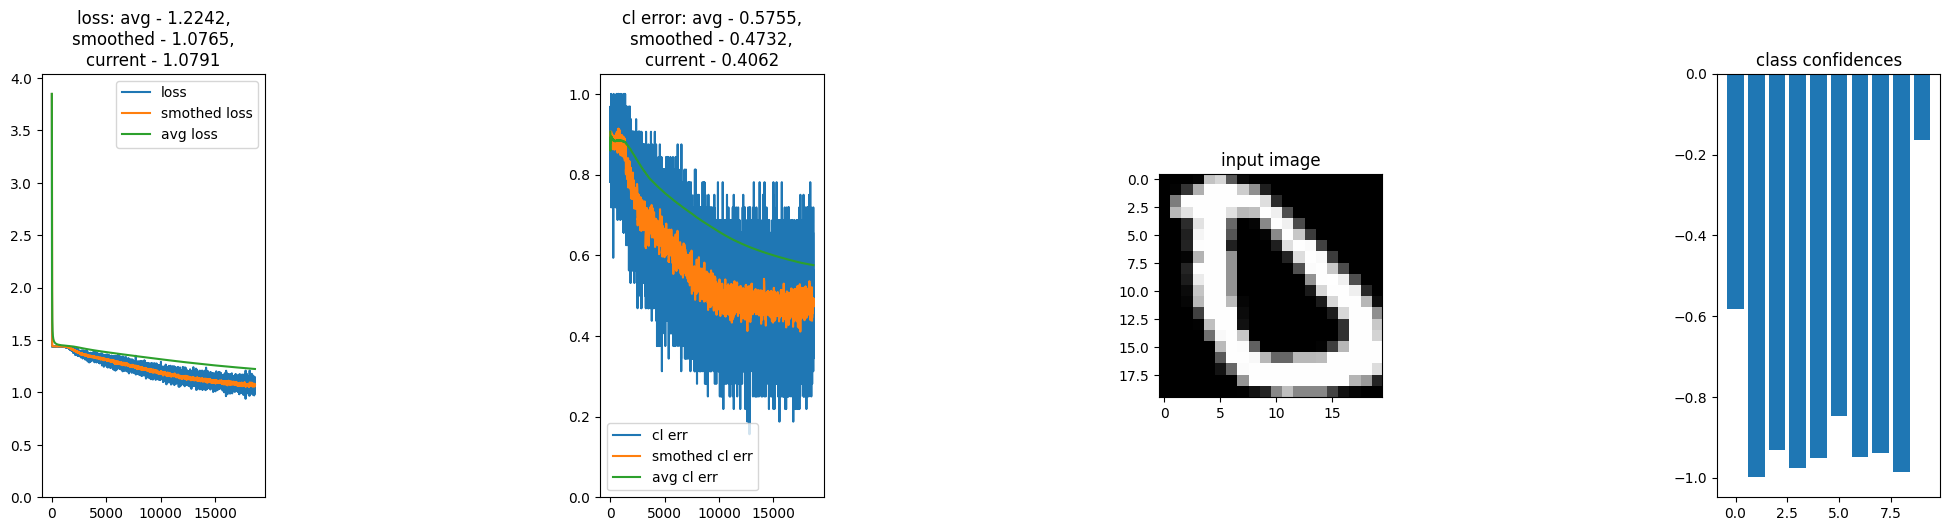

tensor(0, device='cuda:0')
1.0132508277893066 seconds per 200 iterations


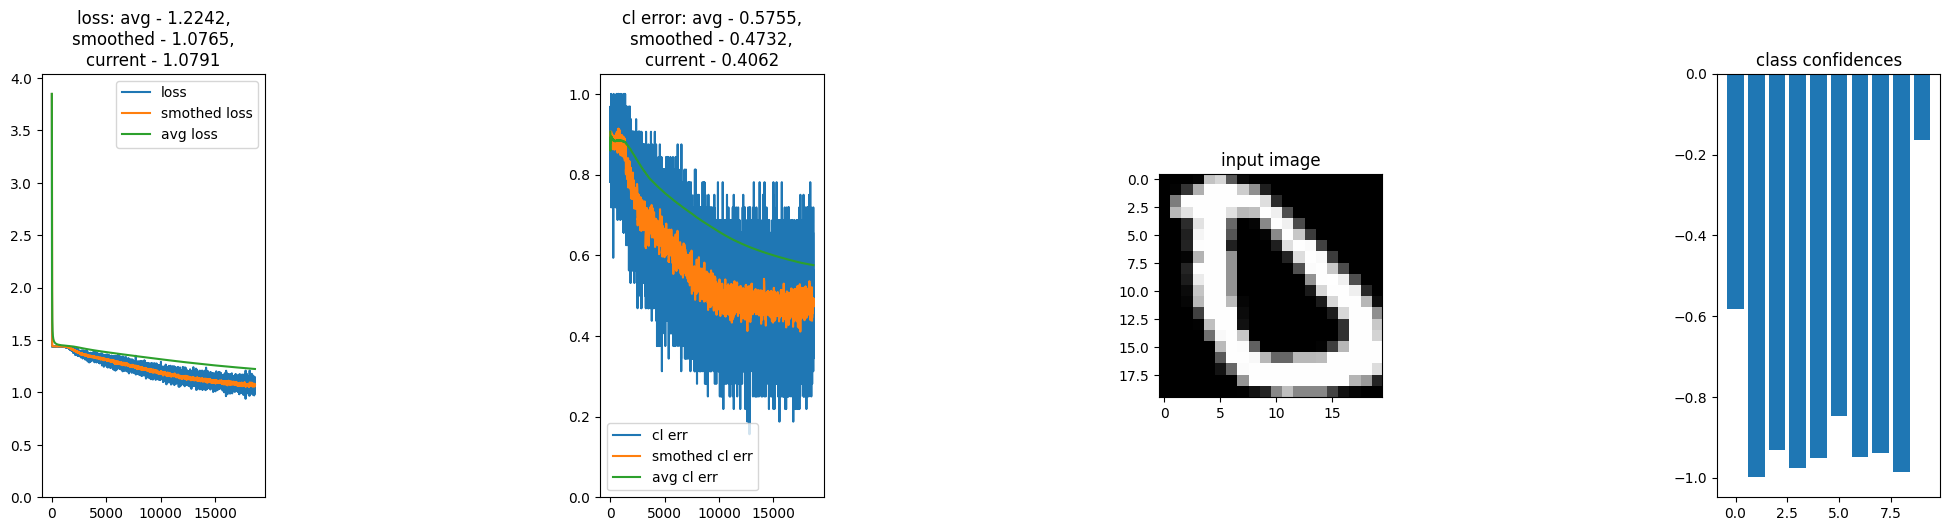

In [20]:
# %%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                   # number of epochs through training set
disp_freq = 200                 # display frequency
batchsize = 32                  # minibatch size
K = 8                         # multiplex

errs = {i:[] for i in range(K)}
losses = []

muxcnn = MuxLeNet(K, 'nonlinear').to(device)

# use SGD optimizer, set learning rate parameter as 0.1
optimizer = optim.SGD(muxcnn.parameters(), lr=0.1)

t_start = time.time()
for iepoch in range(nepoch):
    for t in range(int(ntrain / batchsize)):
        batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
        trainlabels_iter = trainlabels[batchindices]
        trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)
        
        # label 1 for the correct digit and -1 for the incorrect digits
        ys = torch.ones(10, batchsize * K) * (-1)
        ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
        ys = ys.view(-1, K, batchsize).to(device)

        # normalize input images
        imgs = trainimages[batchindices].float() / 255.
        
        comp_imgs = muxcnn.proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

        optimizer.zero_grad()
        outs = muxcnn(comp_imgs)
        loss = 0
        for i, out in enumerate(outs):
            loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
        loss.backward()
        optimizer.step()

        # calculate error rate and loss for plot
        
        for i, out in enumerate(outs):
            pred = torch.argmax(out, dim=1)
            err = torch.mean((pred != trainlabels_iter_sep[i].to(device)).float())
            errs[i].append(err.detach().cpu().numpy())
            if i == 0:
                losses.append(loss.detach().cpu().numpy())


            # plots
            if (t + 1) % disp_freq == 0:
                plt.gcf().clear()
                visualize(len(errs[i]) - 1, losses, errs[i], out[0,:].detach().cpu(), imgs.view(K, batchsize, 20, 20)[i, 0].detach().cpu())
                print(torch.argmax(ys[:, i, 0]))
                print(str(time.time() - t_start) + " seconds per " + str(disp_freq) + " iterations")
                t_start = time.time()
                time.sleep(0.01)

In [21]:

%%time
ntest = testimages.shape[0]

imgs = testimages.float() / 255.
comp_imgs = muxcnn.proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
outs = muxcnn(comp_imgs)

for i, out in enumerate(outs):
    pred = torch.argmax(out, dim=1)
    err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
    print("Test Acc {:.2f}%".format(100 * (1-err)))

Test Acc 29.12%
Test Acc 40.08%
Test Acc 56.88%
Test Acc 25.52%
Test Acc 72.08%
Test Acc 40.48%
Test Acc 73.20%
Test Acc 56.16%
CPU times: user 36 ms, sys: 21.1 ms, total: 57.1 ms
Wall time: 57.5 ms


### Number of Images vs Testing Accuracy

#### mod = rotation

In [16]:
%%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10;                     # number of epochs through training set
batchsize = 32                  # minibatch size
Ks = [1,2,4,8,16]               # multiplex

muxcnns = [MuxLeNet(K, 'rotation').to(device) for K in Ks]

for mi, K in enumerate(Ks):
    print("training a model with {} inputs".format(K))
    optimizer = optim.SGD(muxcnns[mi].parameters(), lr=0.1)
    t_start = time.time()
    for iepoch in range(nepoch):
        for t in range(int(ntrain / batchsize)):
            batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
            trainlabels_iter = trainlabels[batchindices]
            trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)

            # label 1 for the correct digit and -1 for the incorrect digits
            ys = torch.ones(10, batchsize * K) * (-1)
            ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
            ys = ys.view(-1, K, batchsize).to(device)

            # normalize input images
            imgs = trainimages[batchindices].float() / 255.

            comp_imgs = muxcnns[mi].proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

            optimizer.zero_grad()
            outs = muxcnns[mi](comp_imgs)
            loss = 0
            for i, out in enumerate(outs):
                loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
            loss.backward()
            optimizer.step()

training a model with 1 inputs
training a model with 2 inputs
training a model with 4 inputs
training a model with 8 inputs
training a model with 16 inputs
CPU times: user 37min 50s, sys: 9.98 s, total: 38min
Wall time: 38min 59s


In [17]:
%%time
ntest = testimages.shape[0]

## from learnable

mean_test_acc = []

for mi, K in enumerate(Ks):
    imgs = testimages.float() / 255.
    comp_imgs = muxcnns[mi].proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
    outs = muxcnns[mi](comp_imgs)
    
    print("----K={}----".format(K))
    errs = []
    for i, out in enumerate(outs):
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
        errs.append(err.cpu().numpy())
        print("Test Acc {:.2f}%".format(100 * (1-err)))
    mean_test_acc.append(1-np.mean(errs))

----K=1----
Test Acc 97.83%
----K=2----
Test Acc 90.24%
Test Acc 95.48%
----K=4----
Test Acc 36.60%
Test Acc 21.40%
Test Acc 82.96%
Test Acc 94.84%
----K=8----
Test Acc 11.44%
Test Acc 12.08%
Test Acc 13.68%
Test Acc 20.16%
Test Acc 42.48%
Test Acc 53.04%
Test Acc 69.44%
Test Acc 70.56%
----K=16----
Test Acc 11.68%
Test Acc 11.04%
Test Acc 11.36%
Test Acc 11.04%
Test Acc 13.76%
Test Acc 15.52%
Test Acc 17.92%
Test Acc 18.24%
Test Acc 29.92%
Test Acc 23.20%
Test Acc 28.16%
Test Acc 29.76%
Test Acc 40.16%
Test Acc 33.60%
Test Acc 36.48%
Test Acc 39.52%
CPU times: user 4.71 s, sys: 81.1 ms, total: 4.79 s
Wall time: 4.82 s


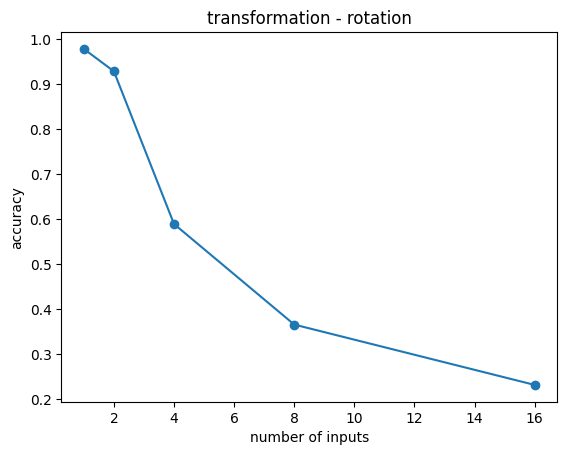

In [18]:
lst_rotation = mean_test_acc
plt.plot(Ks, lst_rotation, 'o-')
plt.xlabel('number of inputs')
plt.ylabel('accuracy')
plt.title('transformation - rotation')
plt.show()

In [19]:
lst_rotation

[0.9783000014722347,
 0.9285999983549118,
 0.5895000100135803,
 0.3661000728607178,
 0.2321000099182129]

#### mod = gaussian

In [20]:
%%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
batchsize = 32                  # minibatch size
Ks = [1,2,4,8,16]               # multiplex

muxcnns = [MuxLeNet(K, 'Gaussian').to(device) for K in Ks]

for mi, K in enumerate(Ks):
    print("training a model with {} inputs".format(K))
    optimizer = optim.SGD(muxcnns[mi].parameters(), lr=0.1)
    t_start = time.time()
    for iepoch in range(nepoch):
        for t in range(int(ntrain / batchsize)):
            batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
            trainlabels_iter = trainlabels[batchindices]
            trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)

            # label 1 for the correct digit and -1 for the incorrect digits
            ys = torch.ones(10, batchsize * K) * (-1)
            ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
            ys = ys.view(-1, K, batchsize).to(device)

            # normalize input images
            imgs = trainimages[batchindices].float() / 255.

            comp_imgs = muxcnns[mi].proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

            optimizer.zero_grad()
            outs = muxcnns[mi](comp_imgs)
            loss = 0
            for i, out in enumerate(outs):
                loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
            loss.backward()
            optimizer.step()

training a model with 1 inputs
training a model with 2 inputs
training a model with 4 inputs
training a model with 8 inputs
training a model with 16 inputs
CPU times: user 9min 48s, sys: 4.71 s, total: 9min 53s
Wall time: 9min 52s


In [21]:
%%time
ntest = testimages.shape[0]

## from learnable

mean_test_acc = []

for mi, K in enumerate(Ks):
    imgs = testimages.float() / 255.
    comp_imgs = muxcnns[mi].proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
    outs = muxcnns[mi](comp_imgs)
    
    print("----K={}----".format(K))
    errs = []
    for i, out in enumerate(outs):
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
        errs.append(err.cpu().numpy())
        print("Test Acc {:.2f}%".format(100 * (1-err)))
    mean_test_acc.append(1-np.mean(errs))

----K=1----
Test Acc 97.50%
----K=2----
Test Acc 93.82%
Test Acc 89.66%
----K=4----
Test Acc 63.52%
Test Acc 81.64%
Test Acc 37.12%
Test Acc 67.36%
----K=8----
Test Acc 54.72%
Test Acc 41.92%
Test Acc 40.88%
Test Acc 19.12%
Test Acc 35.68%
Test Acc 26.96%
Test Acc 65.20%
Test Acc 35.44%
----K=16----
Test Acc 24.32%
Test Acc 13.92%
Test Acc 20.16%
Test Acc 13.60%
Test Acc 24.00%
Test Acc 25.60%
Test Acc 26.40%
Test Acc 22.88%
Test Acc 26.72%
Test Acc 23.84%
Test Acc 30.72%
Test Acc 20.48%
Test Acc 50.72%
Test Acc 38.72%
Test Acc 19.36%
Test Acc 28.32%
CPU times: user 185 ms, sys: 2 ms, total: 187 ms
Wall time: 191 ms


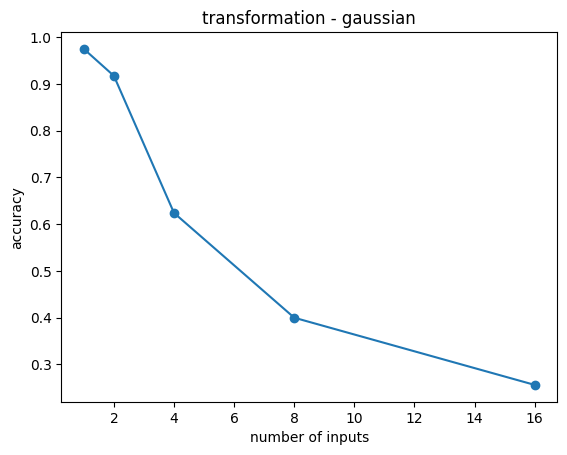

In [28]:
lst_gaussian = mean_test_acc
plt.plot(Ks, lst_gaussian, 'o-')
plt.xlabel('number of inputs')
plt.ylabel('accuracy')
plt.title('transformation - gaussian')
plt.show()

In [23]:
lst_gaussian

[0.9750000014901161,
 0.9174000024795532,
 0.6241000294685364,
 0.39990001916885376,
 0.256100058555603]

#### mod = nonlinear

In [24]:
%%time
ntrain = trainimages.shape[0];  # number of training examples
nepoch = 10                    # number of epochs through training set
batchsize = 32                  # minibatch size
Ks = [1,2,4,8,16]               # multiplex

muxcnns = [MuxLeNet(K, 'nonlinear').to(device) for K in Ks]

for mi, K in enumerate(Ks):
    print("training a model with {} inputs".format(K))
    optimizer = optim.SGD(muxcnns[mi].parameters(), lr=0.1)
    t_start = time.time()
    for iepoch in range(nepoch):
        for t in range(int(ntrain / batchsize)):
            batchindices = np.random.choice(ntrain, batchsize * K, replace=False)
            trainlabels_iter = trainlabels[batchindices]
            trainlabels_iter_sep = trainlabels_iter.view(K, batchsize)

            # label 1 for the correct digit and -1 for the incorrect digits
            ys = torch.ones(10, batchsize * K) * (-1)
            ys[trainlabels_iter, torch.arange(batchsize * K, dtype=torch.int64)] = 1
            ys = ys.view(-1, K, batchsize).to(device)

            # normalize input images
            imgs = trainimages[batchindices].float() / 255.

            comp_imgs = muxcnns[mi].proj(imgs.view(K, batchsize, 1, 20, 20).to(device))

            optimizer.zero_grad()
            outs = muxcnns[mi](comp_imgs)
            loss = 0
            for i, out in enumerate(outs):
                loss += torch.mean(0.5*(ys[:,i,:].t() - out)**2)
            loss.backward()
            optimizer.step()

training a model with 1 inputs
training a model with 2 inputs
training a model with 4 inputs
training a model with 8 inputs
training a model with 16 inputs
CPU times: user 12min 36s, sys: 4.78 s, total: 12min 40s
Wall time: 12min 40s


In [25]:
%%time
ntest = testimages.shape[0]

## from learnable

mean_test_acc = []

for mi, K in enumerate(Ks):
    imgs = testimages.float() / 255.
    comp_imgs = muxcnns[mi].proj(imgs.view(K, ntest//K, 1, 20, 20).to(device))
    outs = muxcnns[mi](comp_imgs)
    
    print("----K={}----".format(K))
    errs = []
    for i, out in enumerate(outs):
        pred = torch.argmax(out, dim=1)
        err = torch.mean((pred != testlabels.view(K, ntest//K)[i].to(device)).float())
        errs.append(err.cpu().numpy())
        print("Test Acc {:.2f}%".format(100 * (1-err)))
    mean_test_acc.append(1-np.mean(errs))

----K=1----
Test Acc 97.67%
----K=2----
Test Acc 92.48%
Test Acc 91.44%
----K=4----
Test Acc 60.84%
Test Acc 85.72%
Test Acc 87.28%
Test Acc 79.36%
----K=8----
Test Acc 51.36%
Test Acc 29.60%
Test Acc 33.28%
Test Acc 52.24%
Test Acc 78.72%
Test Acc 37.20%
Test Acc 60.24%
Test Acc 23.36%
----K=16----
Test Acc 36.16%
Test Acc 31.68%
Test Acc 34.08%
Test Acc 22.40%
Test Acc 24.00%
Test Acc 24.80%
Test Acc 23.04%
Test Acc 32.96%
Test Acc 29.92%
Test Acc 21.60%
Test Acc 21.12%
Test Acc 28.00%
Test Acc 30.72%
Test Acc 25.44%
Test Acc 27.52%
Test Acc 32.00%
CPU times: user 207 ms, sys: 44.1 ms, total: 252 ms
Wall time: 276 ms


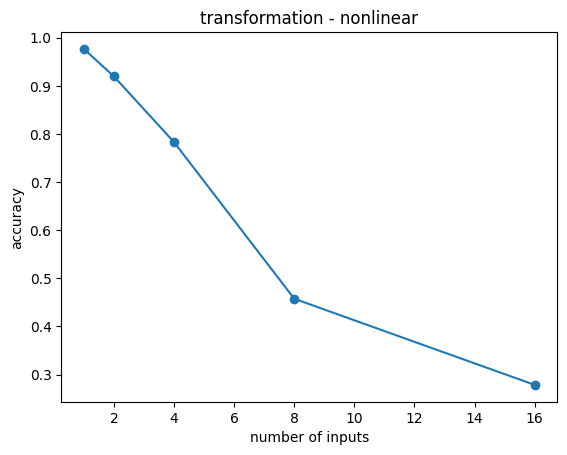

In [26]:
lst_non_linear = mean_test_acc
plt.plot(Ks, lst_non_linear, 'o-')
plt.xlabel('number of inputs')
plt.ylabel('accuracy')
plt.title('transformation - nonlinear')
plt.show()

In [27]:
lst_non_linear

[0.9767000004649162,
 0.9196000024676323,
 0.7830000072717667,
 0.45750004053115845,
 0.2784000635147095]

### comparitive Graphs

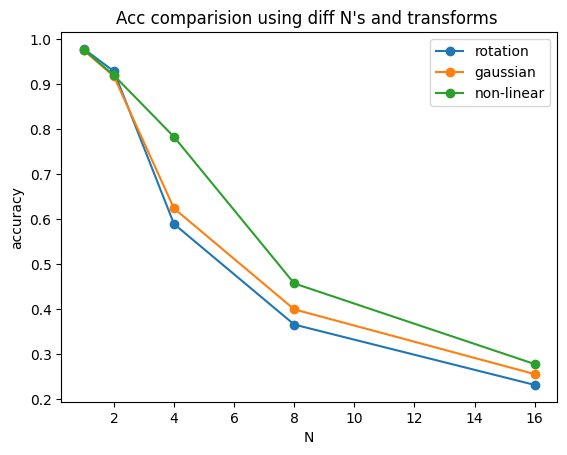

In [30]:
N = [1,2,4,8,16]
plt.plot(N,lst_rotation, 'o-', label = 'rotation')
plt.plot(N,lst_gaussian, 'o-', label = 'gaussian')
plt.plot(N,lst_non_linear, 'o-', label = 'non-linear')
plt.legend()
plt.title('Acc comparision using diff N\'s and transforms ')
plt.xlabel('N')
plt.ylabel('accuracy')
plt.show()

## T-MUX 
<h3>(ran on device, results shown here for consolidation)

values read from their respective lists (taken from their respective output files from python program)

MNLI (natural language inference tasks) <br> AND <br> QQP (sentence similarity task) <br> comparision with 
<br>
B1 - A 12-layer 768 hidden dimension vanilla Transformer
<br>
on Hadamard and ortho

MNLI

In [ ]:
N = [2, 5, 10]

filename = '/content/mnli.txt'

with open(filename, 'r') as f:
    # Read first line with 1 number
    line1 = f.readline().strip()
    baseline = int(line1)
    
    # Read second and third lines with 3 comma-separated values
    line2 = f.readline().strip()
    values2 = line2.split(',')
    mnli_ortho = [int(v) for v in values2]
    
    line3 = f.readline().strip()
    values3 = line3.split(',')
    mnli_hadam = [int(v) for v in values3]


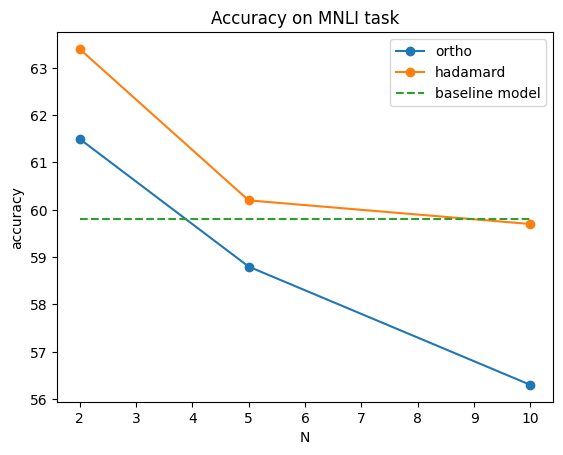

In [ ]:
plt.plot(N, mnli_ortho, 'o-', label = 'ortho')
plt.plot(N, mnli_hadam, 'o-', label = 'hadamard')
plt.plot(N, baseline, linestyle = 'dashed', label='baseline model')
plt.legend()
plt.title('Accuracy on MNLI task')
plt.xlabel('N')
plt.ylabel('accuracy')
plt.show()

QQP

In [ ]:
N = [2, 5, 10]

filename = '/content/qqp.txt'

with open(filename, 'r') as f:
    # Read first line with 1 number
    line1 = f.readline().strip()
    baseline = int(line1)
    
    # Read second and third lines with 3 comma-separated values
    line2 = f.readline().strip()
    values2 = line2.split(',')
    qqp_ortho = [int(v) for v in values2]
    
    line3 = f.readline().strip()
    values3 = line3.split(',')
    qqp_hadam = [int(v) for v in values3]


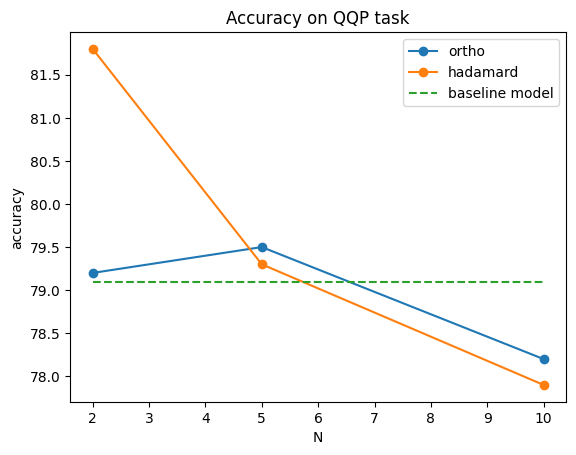

In [ ]:
plt.plot(N, qqp_ortho, 'o-', label = 'ortho')
plt.plot(N, qqp_hadam, 'o-', label = 'hadamard')
plt.plot(N, baseline, linestyle = 'dashed', label='baseline model')
plt.legend()
plt.title('Accuracy on QQP task')
plt.xlabel('N')
plt.ylabel('accuracy')
plt.show()

In [ ]:
N = [2, 5, 10]

filename = '/content/ner.txt'

with open(filename, 'r') as f:
    # Read first line with 1 number
    line1 = f.readline().strip()
    baseline = int(line1)
    
    # Read second and third lines with 3 comma-separated values
    line2 = f.readline().strip()
    values2 = line2.split(',')
    ner_ortho = [int(v) for v in values2]
    
    line3 = f.readline().strip()
    values3 = line3.split(',')
    ner_hadam = [int(v) for v in values3]


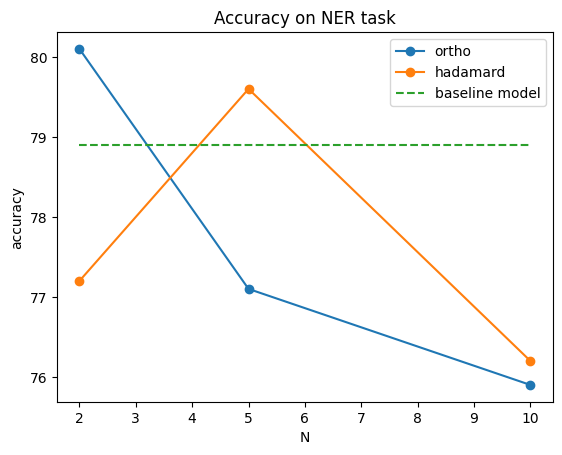

In [ ]:
plt.plot(N, ner_ortho, 'o-', label = 'ortho')
plt.plot(N, ner_hadam, 'o-', label = 'hadamard')
plt.plot(N, baseline, linestyle = 'dashed', label='baseline model')
plt.legend()
plt.title('Accuracy on NER task')
plt.xlabel('N')
plt.ylabel('accuracy')
plt.show()

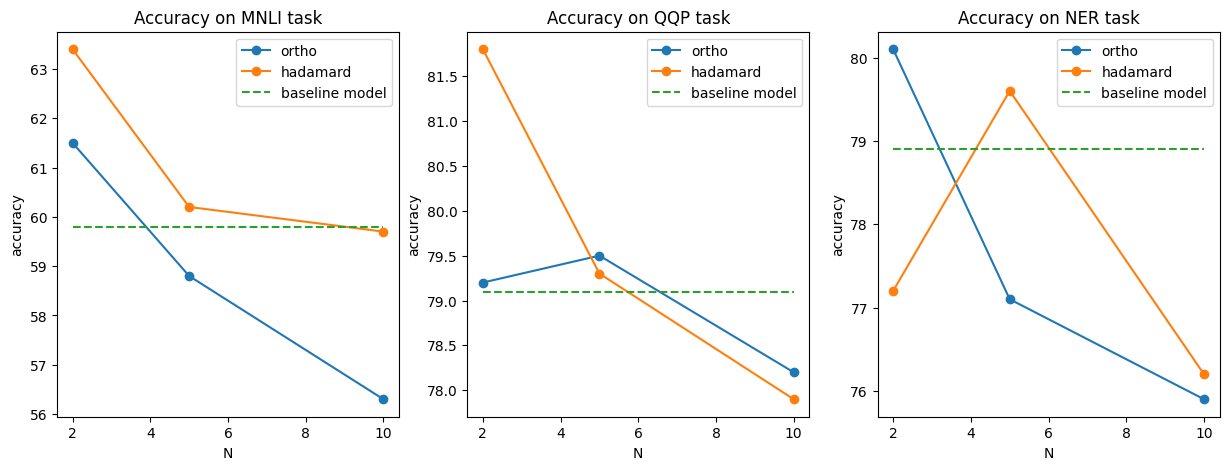

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15,5))

# MNLI task
axs[0].plot(N, mnli_ortho, 'o-', label = 'ortho')
axs[0].plot(N, mnli_hadam, 'o-', label = 'hadamard')
axs[0].plot(N, [59.8]*3, linestyle = 'dashed', label='baseline model')
axs[0].legend()
axs[0].set_title('Accuracy on MNLI task')
axs[0].set_xlabel('N')
axs[0].set_ylabel('accuracy')

# QQP task
axs[1].plot(N, qqp_ortho, 'o-', label = 'ortho')
axs[1].plot(N, qqp_hadam, 'o-', label = 'hadamard')
axs[1].plot(N, [79.1]*3, linestyle = 'dashed', label='baseline model')
axs[1].legend()
axs[1].set_title('Accuracy on QQP task')
axs[1].set_xlabel('N')
axs[1].set_ylabel('accuracy')

# NER task
axs[2].plot(N, ner_ortho, 'o-', label = 'ortho')
axs[2].plot(N, ner_hadam, 'o-', label = 'hadamard')
axs[2].plot(N, [78.9]*3, linestyle = 'dashed', label='baseline model')
axs[2].legend()
axs[2].set_title('Accuracy on NER task')
axs[2].set_xlabel('N')
axs[2].set_ylabel('accuracy')

plt.show()
